In [95]:
%pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:

# Folder path containing CSV files
folder_path = "../../data/run_1"

# List to hold data from each CSV file
data_frames = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        df = df.dropna(subset=['CompanyMentioned'], how='any')

        filtered_df = df[~df['CompanyMentioned'].isin(["False", "false", "Government", "government"])]
        
        # Append the filtered DataFrame to the list
        data_frames.append(filtered_df)

# Concatenate all filtered DataFrames
combined_df = pd.concat(data_frames, ignore_index=True)

df_deduped = combined_df.loc[combined_df.groupby('URL')['Date'].idxmin()]
df_deduped = df_deduped.loc[df_deduped.groupby(['Headline', 'Publication'])['Date'].idxmin()]

print(len(df_deduped)) # result is 192857

df_deduped.to_csv("../../data/distribution_differences/articles_about_companies.csv", index=False)

192857


In [10]:
companies_data = pd.read_csv("../../data/companies.csv")
articles_data = pd.read_csv("../../data/distribution_differences/articles_about_companies.csv")

def preprocess(text):
    # Remove punctuation and convert to lowercase
    if pd.isna(text):
        return ""
    return re.sub(r'[^\w\s]', '', text).lower()

companies_data['name_processed'] = companies_data['name'].apply(preprocess)
articles_data['CompanyMentioned_processed'] = articles_data['CompanyMentioned'].apply(preprocess)

# Perform the join on the lowercase columns
result_df = pd.merge(companies_data, articles_data, left_on='name_processed', right_on='CompanyMentioned_processed', how='inner')

# Drop the helper lowercase columns if desired
result_df = result_df.drop(columns=['name_processed', 'CompanyMentioned_processed'])

result_df.to_csv("../../data/distribution_differences/articles_about_companies_joined_companies.csv", index=False)

In [11]:
duplicate_matches = pd.read_csv("../../data/distribution_differences/articles_about_companies_joined_companies.csv")

# drop duplicate rows by Headline and URL
df_dedup = duplicate_matches.loc[duplicate_matches.groupby(['Headline', 'URL'])['total employee estimate'].idxmax()].reset_index(drop=True)

df_dedup.to_csv("../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv", index=False)

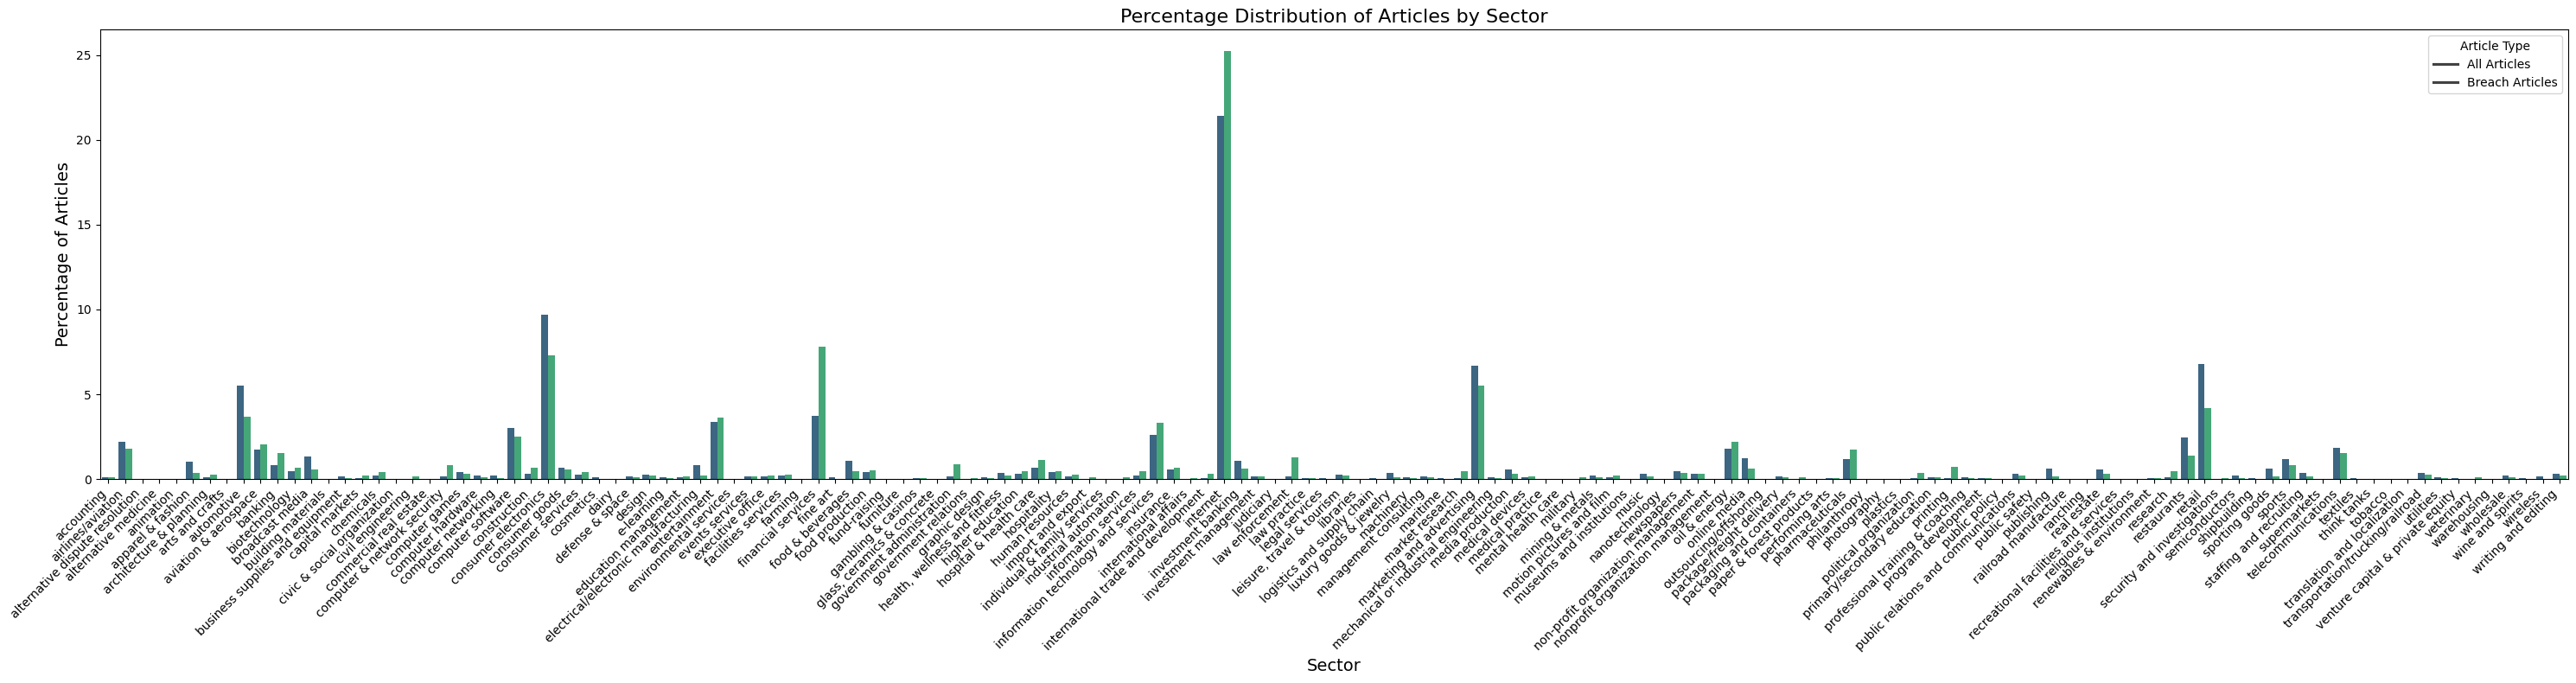

In [ ]:
all_articles_path =  "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
companies_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
companies_articles = pd.read_csv(companies_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
companies_articles_counts = companies_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = companies_articles_counts["count_breach_articles"].sum()
companies_articles_counts["percentage_breach_articles"] = (
    companies_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    companies_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

# Melt the data for plotting
melted = pd.melt(
    sector_percentages,
    id_vars="industry",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(30, 8))
sns.barplot(
    data=melted,
    x="industry",
    y="Percentage",
    hue="Article Type",
    palette="viridis"
)

# Customize plot labels and title
plt.title("Percentage Distribution of Articles by Sector", fontsize=16)
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type", labels=["All Articles", "Breach Articles"])

# Show the plot
plt.tight_layout()
plt.show()

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to your CSV files
all_articles_path = "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
companies_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

# Read the data
all_articles = pd.read_csv(all_articles_path)
companies_articles = pd.read_csv(companies_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
companies_articles_counts = companies_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = companies_articles_counts["count_breach_articles"].sum()
companies_articles_counts["percentage_breach_articles"] = (
    companies_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    companies_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

sector_percentages = sector_percentages.sort_values(by="count_all_articles", ascending=False)


# Save the resulting table to a CSV file
output_file_path = "sector_article_percentages.csv"
sector_percentages.to_csv(output_file_path, index=False)


# Print the resulting table to verify
print(sector_percentages)




# # Plot the data
# melted = pd.melt(
#     sector_percentages,
#     id_vars="industry",
#     value_vars=["percentage_all_articles", "percentage_breach_articles"],
#     var_name="Article Type",
#     value_name="Percentage"
# )

# plt.figure(figsize=(30, 8))
# sns.barplot(
#     data=melted,
#     x="industry",
#     y="Percentage",
#     hue="Article Type",
#     palette="viridis"
# )

# plt.title("Percentage Distribution of Articles by Sector", fontsize=16)
# plt.xlabel("Sector", fontsize=14)
# plt.ylabel("Percentage of Articles", fontsize=14)
# plt.xticks(rotation=45, ha="right")
# plt.legend(title="Article Type", labels=["All Articles", "Breach Articles"])

# plt.tight_layout()
# plt.show()


                           industry  count_all_articles  \
66                         internet               31519   
26             consumer electronics               14275   
124                          retail                9989   
81        marketing and advertising                9871   
8                        automotive                8117   
..                              ...                 ...   
74                        libraries                   3   
2    alternative dispute resolution                   2   
69                        judiciary                   2   
92                   nanotechnology                   1   
117                        ranching                   1   

     percentage_all_articles  count_breach_articles  \
66                 21.402332                 3199.0   
26                  9.693147                  926.0   
124                 6.782826                  530.0   
81                  6.702701                  699.0   
8               

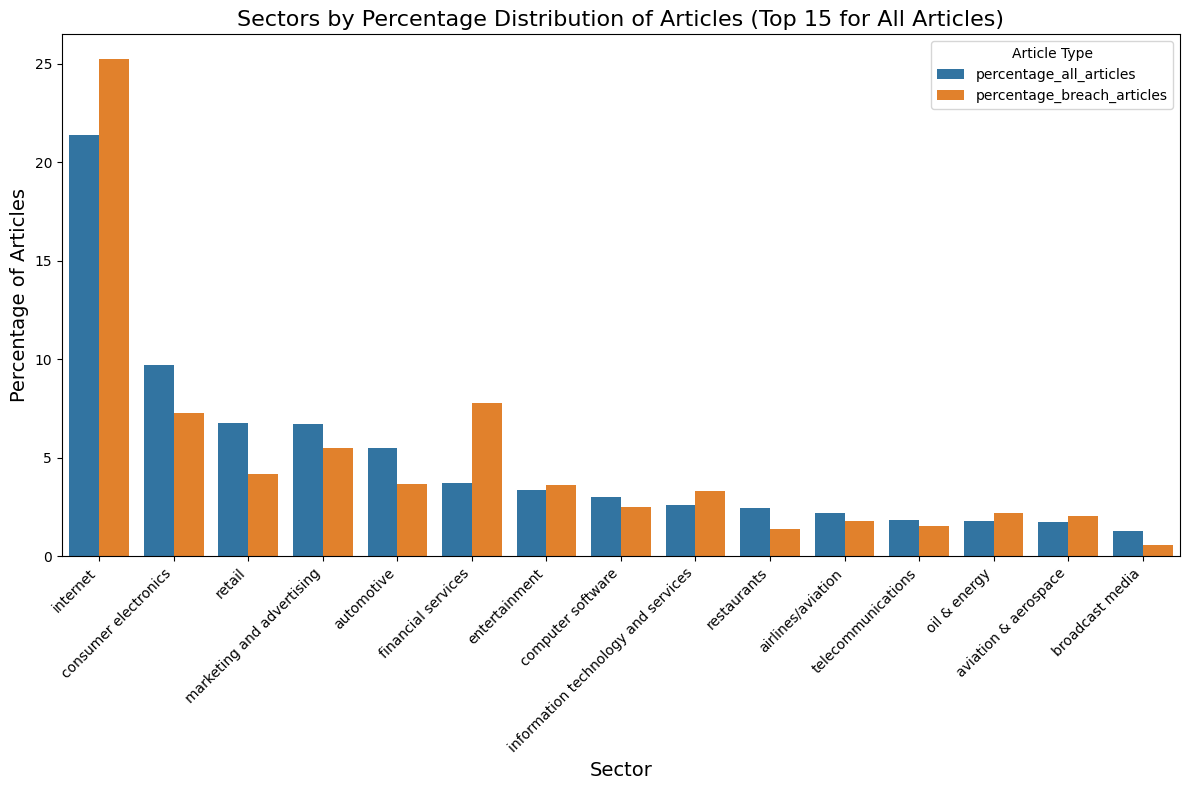

In [47]:
# top 15 

all_articles_path =  "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
breach_articles_counts = breach_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = breach_articles_counts["count_breach_articles"].sum()
breach_articles_counts["percentage_breach_articles"] = (
    breach_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

top_15_sectors = sector_percentages.sort_values(by="count_all_articles", ascending=False).head(15)

# Melt the data for plotting
melted = pd.melt(
    top_15_sectors,
    id_vars="industry",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="industry",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

# Customize plot labels and title
plt.title("Sectors by Percentage Distribution of Articles (Top 15 for All Articles)", fontsize=16)
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()

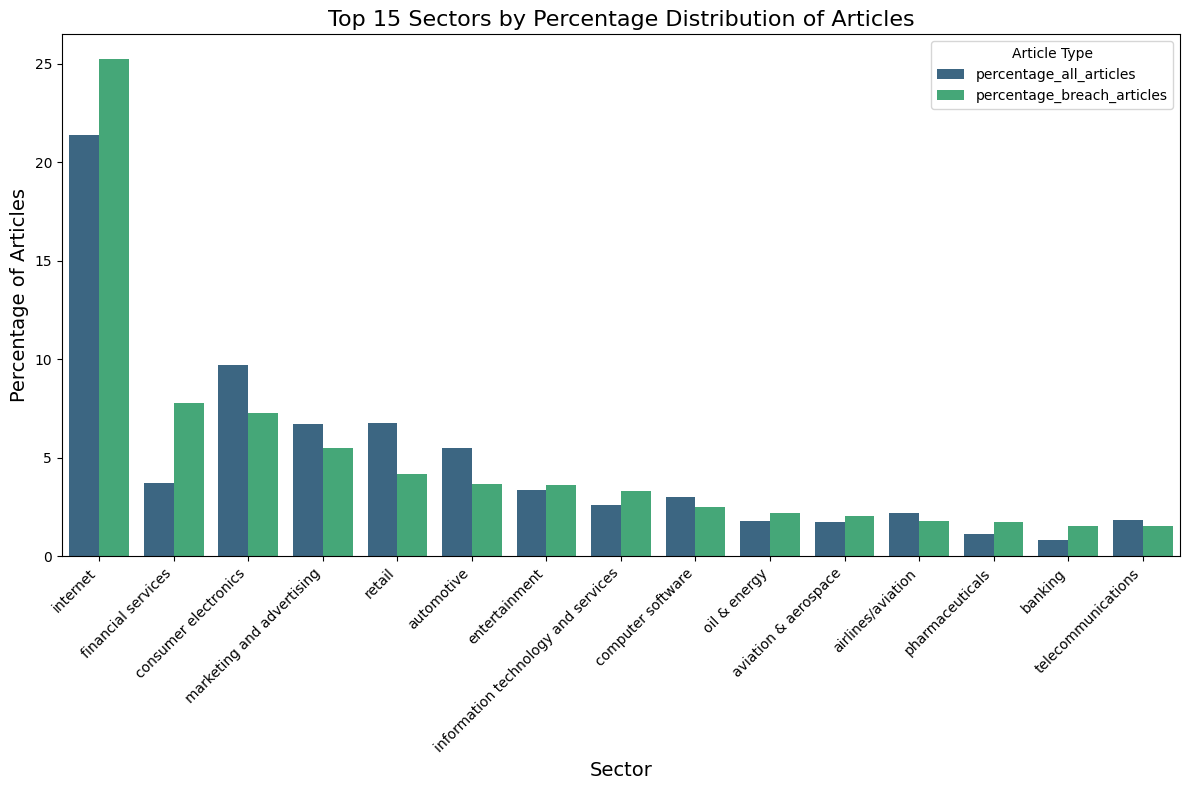

In [46]:
# top 15 

all_articles_path =  "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
breach_articles_counts = breach_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = breach_articles_counts["count_breach_articles"].sum()
breach_articles_counts["percentage_breach_articles"] = (
    breach_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

top_15_sectors = sector_percentages.sort_values(by="count_breach_articles", ascending=False).head(15)

# Melt the data for plotting
melted = pd.melt(
    top_15_sectors,
    id_vars="industry",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="industry",
    y="Percentage",
    hue="Article Type",
    palette="viridis"
)

# Customize plot labels and title
plt.title("Top 15 Sectors by Percentage Distribution of Articles", fontsize=16)
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()

In [52]:
all_articles_path =  "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_path = "../../data/breaches/breaches_information.csv"

all_articles = pd.read_csv(all_articles_path)
industry_unique_values = all_articles['industry'].unique()

breaches = pd.read_csv(breach_path, skiprows=range(1, 2))
sector_unique_values = breaches['sector'].unique()


with open('unique_names.txt', 'w') as file:
    for name in industry_unique_values:
        file.write(f"{name}\n")

    file.write(f"\n\n")
    for name in sector_unique_values:
        file.write(f"{name}\n")

get sector and industry values from breaches and comapnies dataset, respectively.

C:\Users\12537\AppData\Local\Temp\ipykernel_36568\3559511509.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_articles, x='sector', y='average_articles_per_breach', palette='viridis')


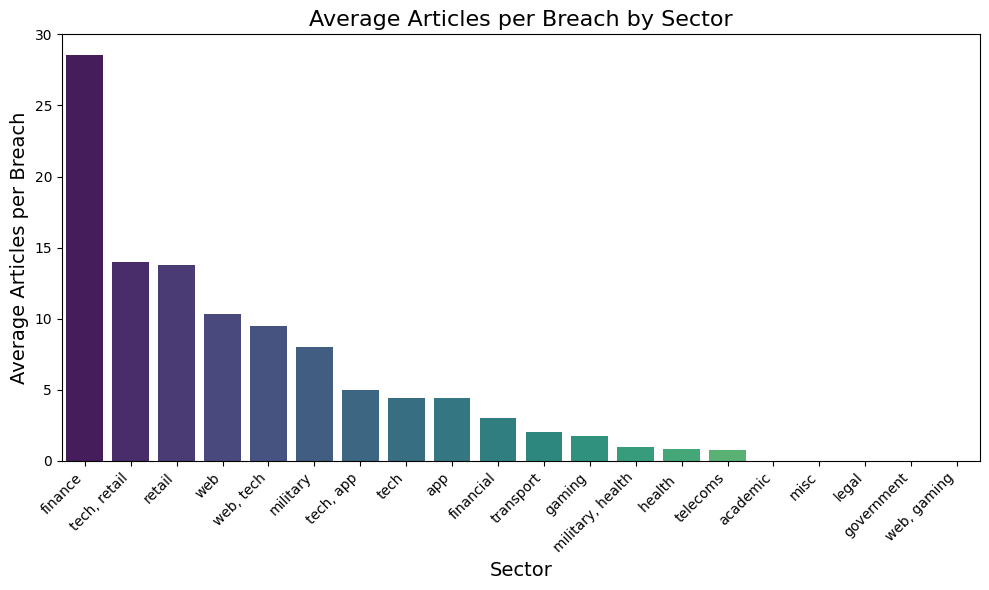

In [53]:
#vdf = pd.read_csv("./test_data/article_count_per_breach.csv") # test data

df = pd.read_csv("../../data/article_company_breach/article_count_per_breach.csv")

sector_articles = df.groupby('sector').agg(
    total_articles=('number of articles', 'sum'),
    total_breaches=('sector', 'count')
)

# Calculate the average number of articles per breach for each sector
sector_articles['average_articles_per_breach'] = sector_articles['total_articles'] / sector_articles['total_breaches']

sector_articles.sort_values(by='average_articles_per_breach', ascending=False, inplace=True)

# Reset index for better plotting
sector_articles.reset_index(inplace=True)

# Create a Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=sector_articles, x='sector', y='average_articles_per_breach', palette='viridis')

# Add labels and title
plt.title('Average Articles per Breach by Sector', fontsize=16)
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Average Articles per Breach', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\12537\AppData\Local\Temp\ipykernel_36568\1941632590.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_articles, x='industry', y='average_articles_per_breach', palette='viridis')


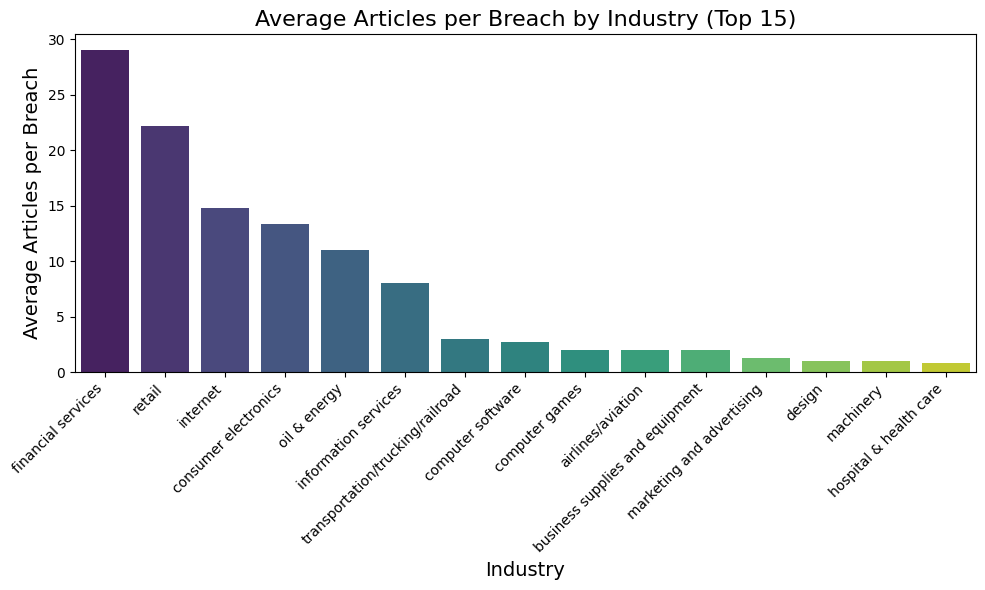

In [54]:
#vdf = pd.read_csv("./test_data/article_count_per_breach.csv") # test data

df = pd.read_csv("../../data/article_company_breach/article_count_per_breach.csv")

sector_articles = df.groupby('industry').agg(
    total_articles=('number of articles', 'sum'),
    total_breaches=('industry', 'count')
)

# Calculate the average number of articles per breach for each sector
sector_articles['average_articles_per_breach'] = sector_articles['total_articles'] / sector_articles['total_breaches']

sector_articles.sort_values(by='average_articles_per_breach', ascending=False, inplace=True)

# Reset index for better plotting
sector_articles.reset_index(inplace=True)

sector_articles = sector_articles.head(15)

# Create a Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=sector_articles, x='industry', y='average_articles_per_breach', palette='viridis')

# Add labels and title
plt.title('Average Articles per Breach by Industry (Top 15)', fontsize=16)
plt.xlabel('Industry', fontsize=14)
plt.ylabel('Average Articles per Breach', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\12537\AppData\Local\Temp\ipykernel_36568\2955636024.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_articles, x='industry', y='average_articles_per_breach', palette='viridis')


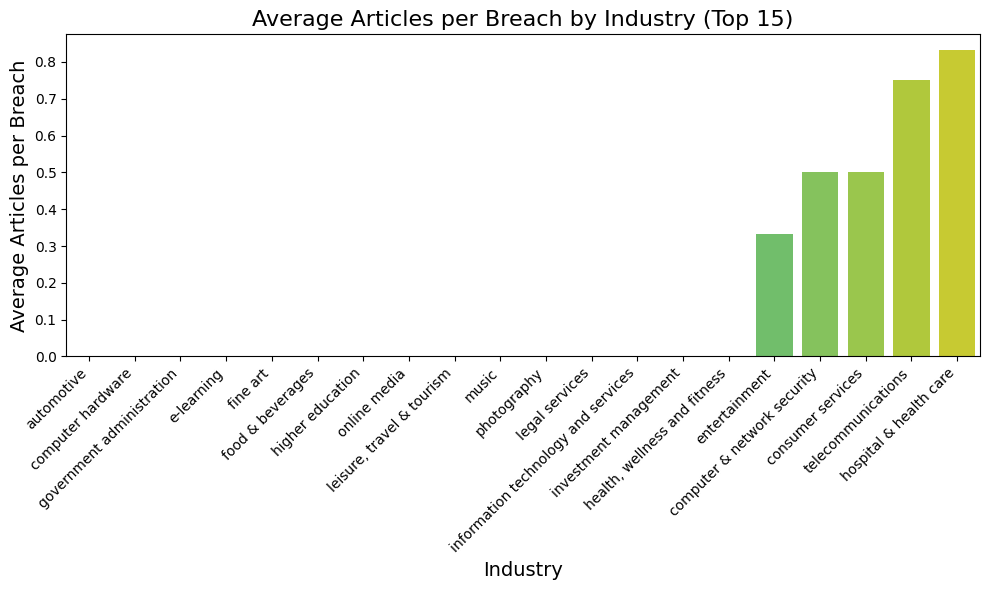

In [55]:
#vdf = pd.read_csv("./test_data/article_count_per_breach.csv") # test data

df = pd.read_csv("../../data/article_company_breach/article_count_per_breach.csv")

sector_articles = df.groupby('industry').agg(
    total_articles=('number of articles', 'sum'),
    total_breaches=('industry', 'count')
)

# Calculate the average number of articles per breach for each sector
sector_articles['average_articles_per_breach'] = sector_articles['total_articles'] / sector_articles['total_breaches']

sector_articles.sort_values(by='average_articles_per_breach', ascending=True, inplace=True)

# Reset index for better plotting
sector_articles.reset_index(inplace=True)

sector_articles = sector_articles.head(20)

# Create a Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=sector_articles, x='industry', y='average_articles_per_breach', palette='viridis')

# Add labels and title
plt.title('Average Articles per Breach by Industry (Top 15)', fontsize=16)
plt.xlabel('Industry', fontsize=14)
plt.ylabel('Average Articles per Breach', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\12537\AppData\Local\Temp\ipykernel_36568\3026757374.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_articles_counts = all_articles.groupby("year_bin").size().reset_index(name="count_all_articles")
C:\Users\12537\AppData\Local\Temp\ipykernel_36568\3026757374.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  breach_articles_counts = breach_articles.groupby("year_bin").size().reset_index(name="count_breach_articles")


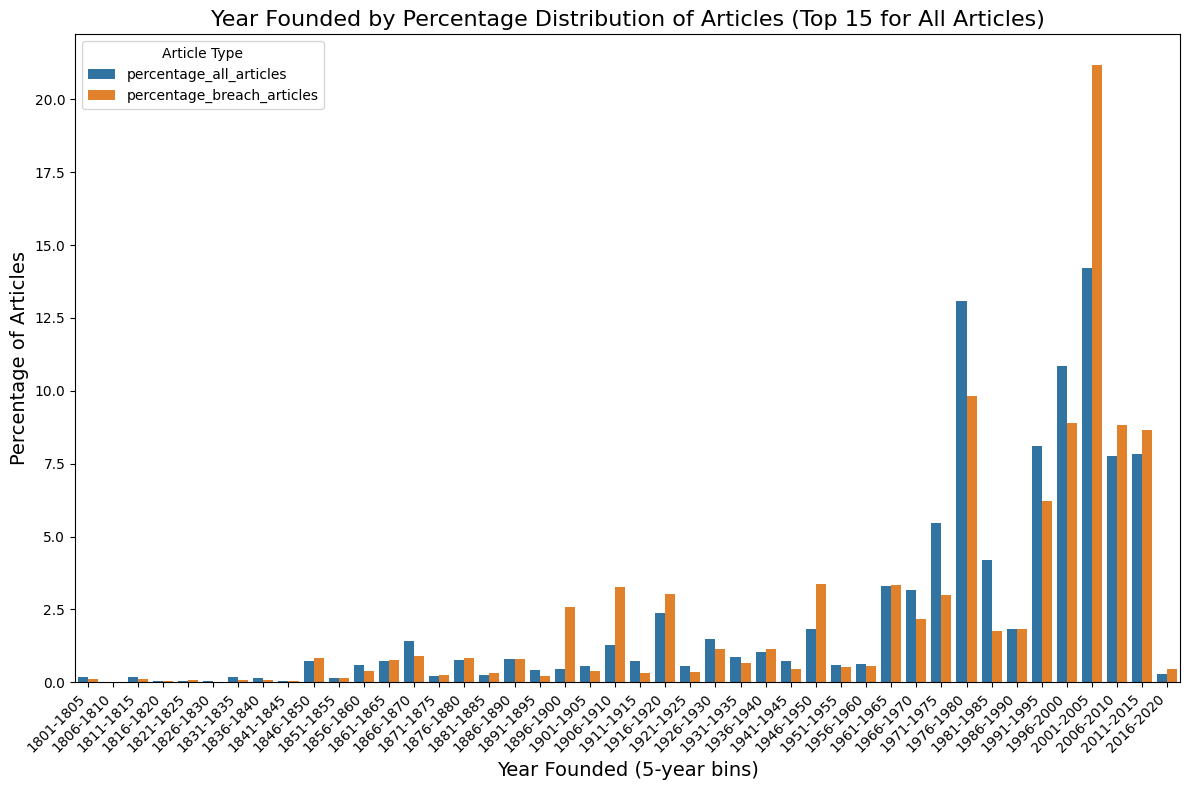

In [86]:


# Read the data
all_articles_path = "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

all_articles = all_articles.dropna(subset=['year founded'])
breach_articles = breach_articles.dropna(subset=['year founded'])


all_articles['year founded'] = all_articles['year founded'].astype(int)
breach_articles['year founded'] = breach_articles['year founded'].astype(int)

# Bin "year founded" into 5-year intervals
bins = range(all_articles["year founded"].min(), all_articles["year founded"].max() + 5, 5)
labels = [f"{i}-{i + 4}" for i in bins[:-1]]
all_articles["year_bin"] = pd.cut(all_articles["year founded"], bins=bins, labels=labels, right=False)
breach_articles["year_bin"] = pd.cut(breach_articles["year founded"], bins=bins, labels=labels, right=False)

# Group and count articles by year_bin for all articles
all_articles_counts = all_articles.groupby("year_bin").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by year_bin for breach articles
breach_articles_counts = breach_articles.groupby("year_bin").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = breach_articles_counts["count_breach_articles"].sum()
breach_articles_counts["percentage_breach_articles"] = (
    breach_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on year_bin
year_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="year_bin",
    how="outer"
)

# Fill missing values with 0
#year_percentages.fillna(0, inplace=True)

# Sort by count_all_articles and select the top bins (optional)
top_15_years = year_percentages.sort_values(by="count_all_articles", ascending=False)

# Save the resulting table to a CSV file
output_file_path = "./output/year_founded_article_percentages.csv"
top_15_years.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    top_15_years,
    id_vars="year_bin",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="year_bin",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

# Customize plot labels and title
plt.title("Year Founded by Percentage Distribution of Articles (Top 15 for All Articles)", fontsize=16)
plt.xlabel("Year Founded (5-year bins)", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\12537\AppData\Local\Temp\ipykernel_36568\2368144064.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_articles, x='year founded', y='total_companies', palette='tab10')


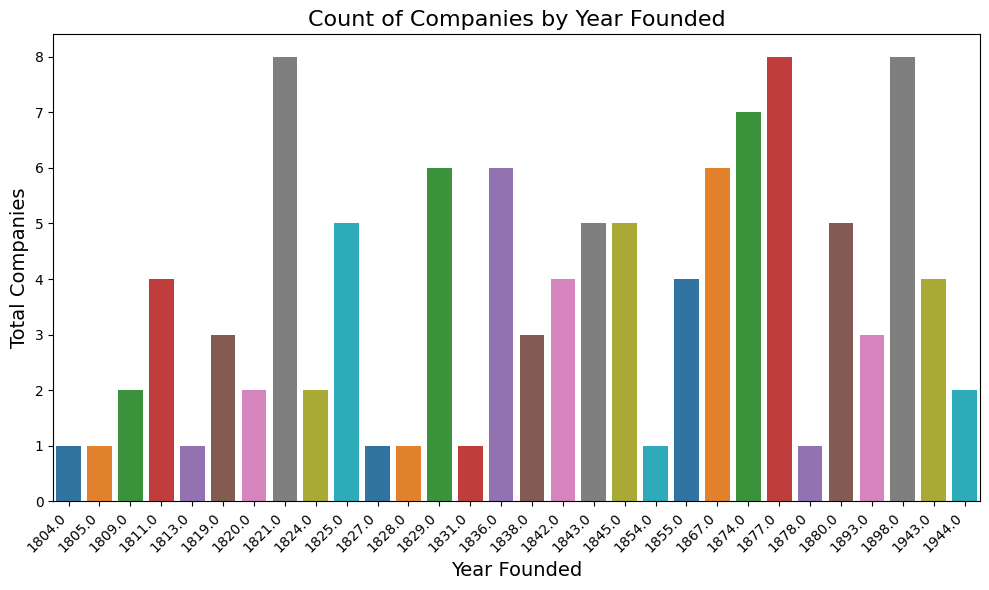

In [77]:
# Read data
df = pd.read_csv("../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv")

# Group by 'year founded' and count the number of companies
sector_articles = df.groupby('year founded').agg(
    total_companies=('year founded', 'count')
).reset_index()  # Reset index for proper access to 'year founded' column

# Sort by the count of companies
sector_articles.sort_values(by='total_companies', ascending=False, inplace=True)

# Take the top 15 rows (optional, depending on your data)
sector_articles = sector_articles.tail(30)

# Create a Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=sector_articles, x='year founded', y='total_companies', palette='tab10')

# Add labels and title
plt.title('Count of Companies by Year Founded', fontsize=16)
plt.xlabel('Year Founded', fontsize=14)
plt.ylabel('Total Companies', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


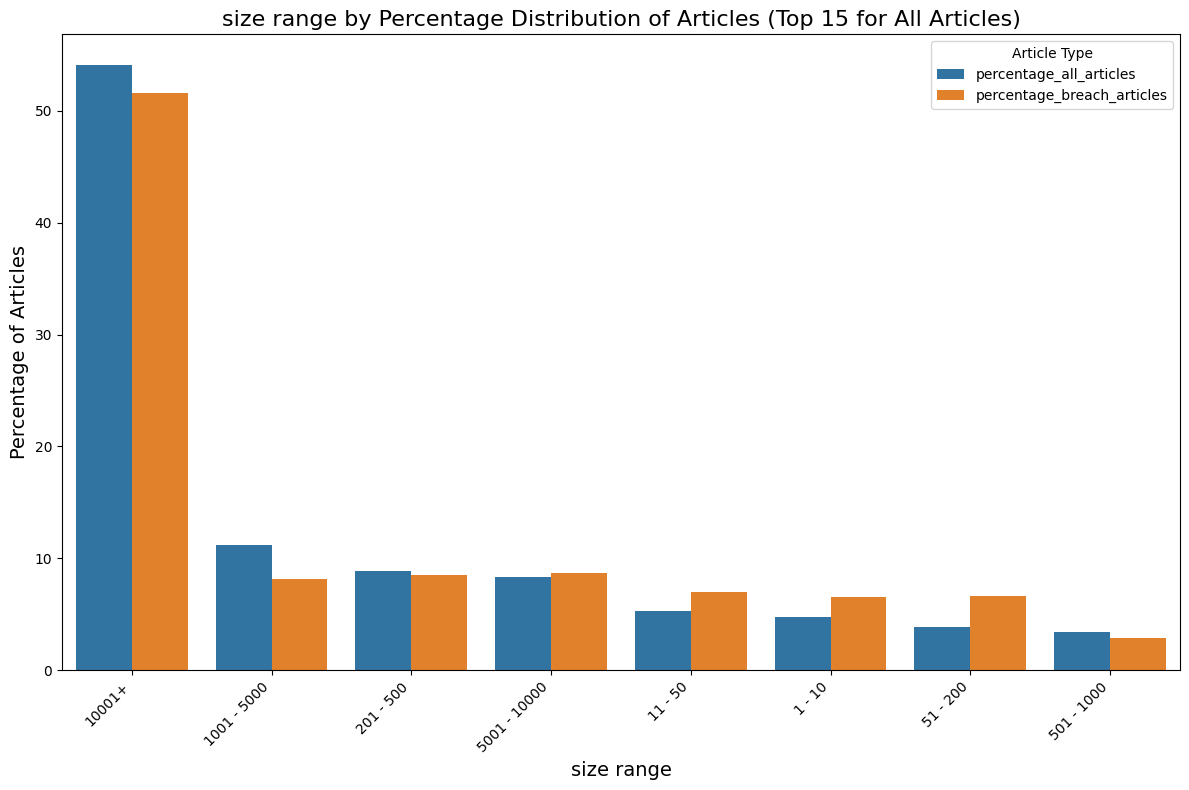

In [87]:
all_articles_path =  "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("size range").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
breach_articles_counts = breach_articles.groupby("size range").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = breach_articles_counts["count_breach_articles"].sum()
breach_articles_counts["percentage_breach_articles"] = (
    breach_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="size range",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

top_15_sectors = sector_percentages.sort_values(by="count_all_articles", ascending=False).head(15)

# Save the resulting table to a CSV file
output_file_path = "./output/size_article_percentages.csv"
top_15_sectors.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    top_15_sectors,
    id_vars="size range",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="size range",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

# Customize plot labels and title
plt.title("size range by Percentage Distribution of Articles (Top 15 for All Articles)", fontsize=16)
plt.xlabel("size range", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()

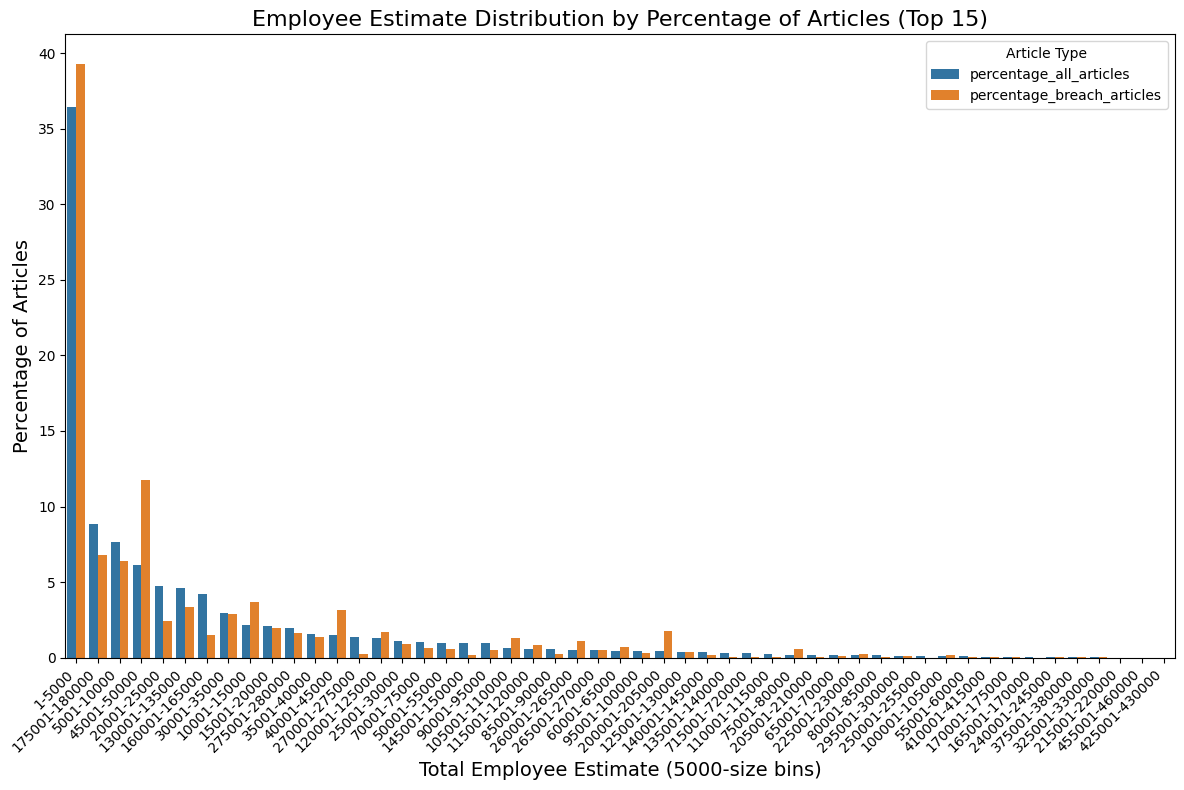

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
all_articles_path = "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

# Drop rows with missing values in 'total employee estimate'
all_articles = all_articles.dropna(subset=['total employee estimate'])
breach_articles = breach_articles.dropna(subset=['total employee estimate'])

# Convert 'total employee estimate' to integer
all_articles['total employee estimate'] = all_articles['total employee estimate'].astype(int)
breach_articles['total employee estimate'] = breach_articles['total employee estimate'].astype(int)

# Bin "total employee estimate" into 5000-size intervals
bins = range(all_articles['total employee estimate'].min(), 
             all_articles['total employee estimate'].max() + 5000, 
             5000)
labels = [f"{i}-{i + 4999}" for i in bins[:-1]]

# Create the bins for both datasets
all_articles["employee_bin"] = pd.cut(all_articles["total employee estimate"], bins=bins, labels=labels, right=False)
breach_articles["employee_bin"] = pd.cut(breach_articles["total employee estimate"], bins=bins, labels=labels, right=False)

# Convert the categorical 'employee_bin' to string
all_articles["employee_bin"] = all_articles["employee_bin"].astype(str)
breach_articles["employee_bin"] = breach_articles["employee_bin"].astype(str)

# Group and count articles by 'employee_bin' for both datasets
all_articles_counts = all_articles.groupby("employee_bin").size().reset_index(name="count_all_articles")
breach_articles_counts = breach_articles.groupby("employee_bin").size().reset_index(name="count_breach_articles")

# Merge the two dataframes on 'employee_bin'
employee_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="employee_bin",
    how="outer"
)

# Fill missing values in numeric columns with 0
employee_percentages.loc[:, employee_percentages.select_dtypes(include='number').columns] = (
    employee_percentages.select_dtypes(include='number').fillna(0)
)

# Calculate percentages for both datasets
total_all_articles = employee_percentages["count_all_articles"].sum()
total_breach_articles = employee_percentages["count_breach_articles"].sum()

employee_percentages["percentage_all_articles"] = (
    employee_percentages["count_all_articles"] / total_all_articles * 100
)
employee_percentages["percentage_breach_articles"] = (
    employee_percentages["count_breach_articles"] / total_breach_articles * 100
)

# Sort by 'count_all_articles' and select the top bins
top_15_bins = employee_percentages.sort_values(by="count_all_articles", ascending=False)

# Save the resulting table to a CSV file
output_file_path = "./output/employees_article_percentages.csv"
top_15_bins.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    top_15_bins,
    id_vars="employee_bin",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="employee_bin",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

# Customize plot labels and title
plt.title("Employee Estimate Distribution by Percentage of Articles (Top 15)", fontsize=16)
plt.xlabel("Total Employee Estimate (5000-size bins)", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()


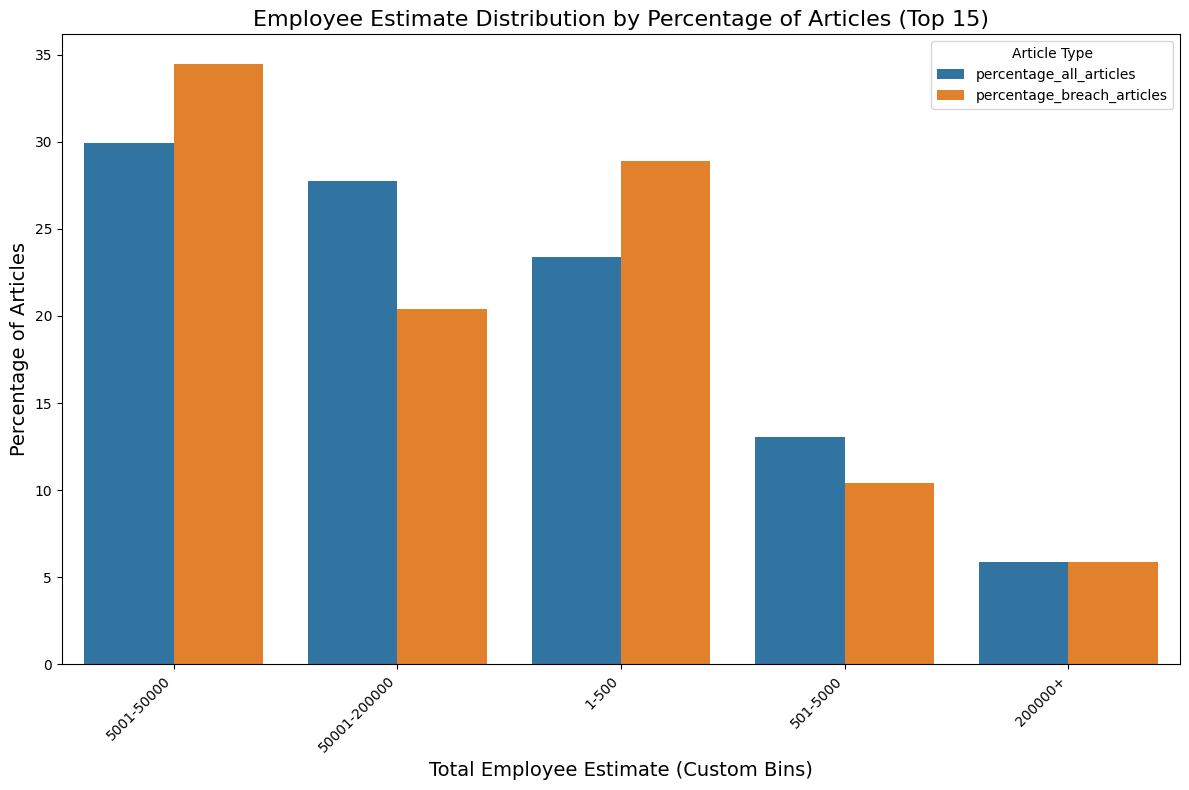

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
all_articles_path = "../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

# Drop rows with missing values in 'total employee estimate'
all_articles = all_articles.dropna(subset=['total employee estimate'])
breach_articles = breach_articles.dropna(subset=['total employee estimate'])

# Convert 'total employee estimate' to integer
all_articles['total employee estimate'] = all_articles['total employee estimate'].astype(int)
breach_articles['total employee estimate'] = breach_articles['total employee estimate'].astype(int)

# Define custom bins and labels for employee estimate categories
bins = [1, 500, 5000, 50000, 200000, float('inf')]  # Bins for 1-500, 501-5000, 5001-50000, 50001-200000, and 200000+
labels = ["1-500", "501-5000", "5001-50000", "50001-200000", "200000+"]

# Create the bins for both datasets
all_articles["employee_bin"] = pd.cut(all_articles["total employee estimate"], bins=bins, labels=labels, right=False)
breach_articles["employee_bin"] = pd.cut(breach_articles["total employee estimate"], bins=bins, labels=labels, right=False)

# Convert the categorical 'employee_bin' to string
all_articles["employee_bin"] = all_articles["employee_bin"].astype(str)
breach_articles["employee_bin"] = breach_articles["employee_bin"].astype(str)

# Group and count articles by 'employee_bin' for both datasets
all_articles_counts = all_articles.groupby("employee_bin").size().reset_index(name="count_all_articles")
breach_articles_counts = breach_articles.groupby("employee_bin").size().reset_index(name="count_breach_articles")

# Merge the two dataframes on 'employee_bin'
employee_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="employee_bin",
    how="outer"
)

# Fill missing values in numeric columns with 0
employee_percentages.loc[:, employee_percentages.select_dtypes(include='number').columns] = (
    employee_percentages.select_dtypes(include='number').fillna(0)
)

# Calculate percentages for both datasets
total_all_articles = employee_percentages["count_all_articles"].sum()
total_breach_articles = employee_percentages["count_breach_articles"].sum()

employee_percentages["percentage_all_articles"] = (
    employee_percentages["count_all_articles"] / total_all_articles * 100
)
employee_percentages["percentage_breach_articles"] = (
    employee_percentages["count_breach_articles"] / total_breach_articles * 100
)

# Sort by 'count_all_articles' and select the top bins
top_15_bins = employee_percentages.sort_values(by="count_all_articles", ascending=False)

# Save the resulting table to a CSV file
output_file_path = "./output/employees_article_percentages.csv"
top_15_bins.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    top_15_bins,
    id_vars="employee_bin",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="employee_bin",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

# Customize plot labels and title
plt.title("Employee Estimate Distribution by Percentage of Articles (Top 15)", fontsize=16)
plt.xlabel("Total Employee Estimate (Custom Bins)", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()


## companies in data breaches to companies in articles about data breaches

C:\Users\12537\AppData\Local\Temp\ipykernel_36568\3580955468.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_articles_counts = all_articles.groupby("employee_bin").size().reset_index(name="count_all_articles")
C:\Users\12537\AppData\Local\Temp\ipykernel_36568\3580955468.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  breach_articles_counts = breach_articles.groupby("employee_bin").size().reset_index(name="count_breach_articles")


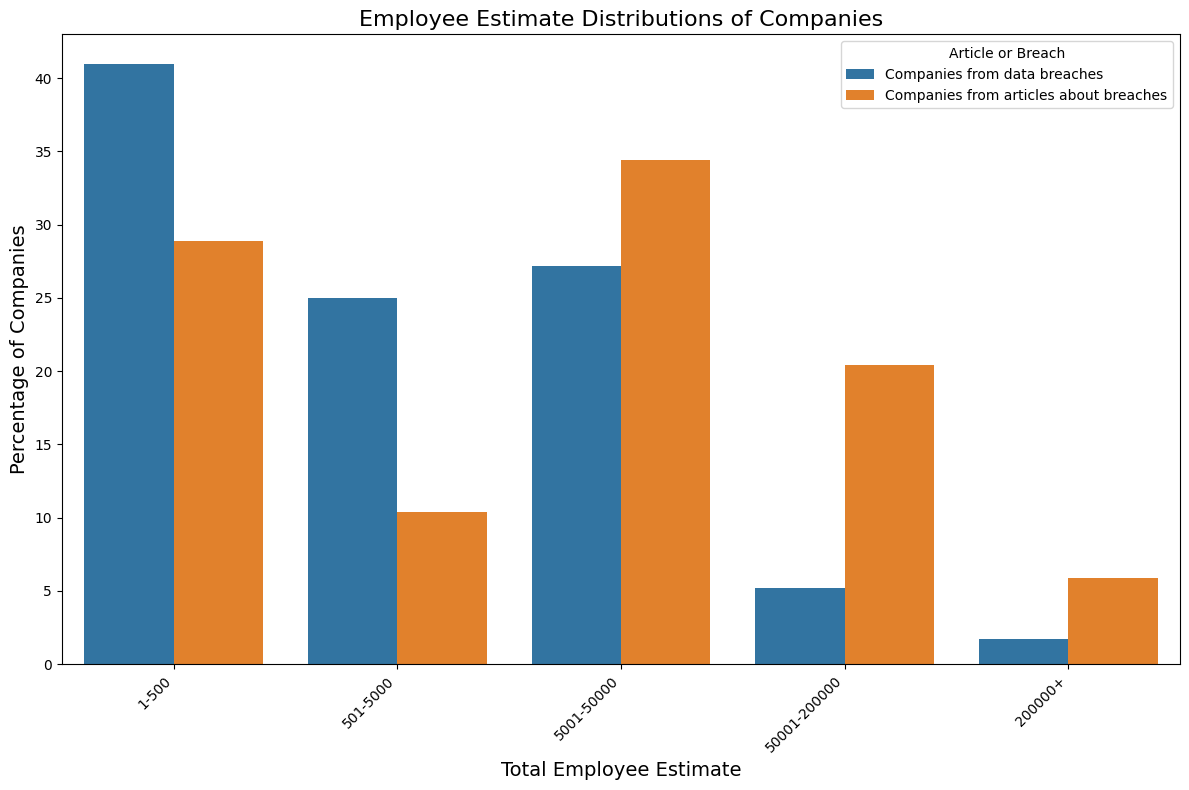

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data
# breaches_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
# breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"


# Read the data
all_articles_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

all_articles['total employee estimate'] = all_articles['total employee estimate'].replace(-1, np.nan)

# Drop rows with missing values in 'total employee estimate'
all_articles = all_articles.dropna(subset=['total employee estimate'])
breach_articles = breach_articles.dropna(subset=['total employee estimate'])

import numpy as np  # Make sure to import numpy

# Define custom bins and labels for employee estimate categories
bins = [1, 500, 5000, 50000, 200000, float('inf')]  # Bins for 1-500, 501-5000, 5001-50000, 50001-200000, and 200000+
labels = ["1-500", "501-5000", "5001-50000", "50001-200000", "200000+"]

# Create the bins for both datasets
all_articles["employee_bin"] = pd.cut(all_articles["total employee estimate"], bins=bins, labels=labels, right=False)
breach_articles["employee_bin"] = pd.cut(breach_articles["total employee estimate"], bins=bins, labels=labels, right=False)

# Ensure 'employee_bin' is a categorical column with the specified order
category_order = ["1-500", "501-5000", "5001-50000", "50001-200000", "200000+"]
all_articles["employee_bin"] = pd.Categorical(all_articles["employee_bin"], categories=category_order, ordered=True)
breach_articles["employee_bin"] = pd.Categorical(breach_articles["employee_bin"], categories=category_order, ordered=True)

# Group and count articles by 'employee_bin' for both datasets
all_articles_counts = all_articles.groupby("employee_bin").size().reset_index(name="count_all_articles")
breach_articles_counts = breach_articles.groupby("employee_bin").size().reset_index(name="count_breach_articles")

# Merge the two dataframes on 'employee_bin'
employee_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="employee_bin",
    how="outer"
)

# Fill missing values in numeric columns with 0
employee_percentages.loc[:, employee_percentages.select_dtypes(include='number').columns] = (
    employee_percentages.select_dtypes(include='number').fillna(0)
)

# Calculate percentages for both datasets
total_all_articles = employee_percentages["count_all_articles"].sum()
total_breach_articles = employee_percentages["count_breach_articles"].sum()

employee_percentages["Companies from data breaches"] = (
    employee_percentages["count_all_articles"] / total_all_articles * 100
)
employee_percentages["Companies from articles about breaches"] = (
    employee_percentages["count_breach_articles"] / total_breach_articles * 100
)

# Ensure custom sorting persists in the final dataframe
employee_percentages["employee_bin"] = pd.Categorical(employee_percentages["employee_bin"], categories=category_order, ordered=True)

# Save the resulting table to a CSV file
output_file_path = "./output/employees_breach_companies_percentages.csv"
employee_percentages.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    employee_percentages,
    id_vars="employee_bin",
    value_vars=["Companies from data breaches", "Companies from articles about breaches"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="employee_bin",
    y="Percentage",
    hue="Article Type",
    palette="tab10",
    order=category_order  # Apply custom sort order to the x-axis
)

# Customize plot labels and title
plt.title("Employee Estimate Distributions of Companies", fontsize=16)
plt.xlabel("Total Employee Estimate", fontsize=14)
plt.ylabel("Percentage of Companies", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article or Breach")

# Show the plot
plt.tight_layout()
plt.show()




['10001+' '201 - 500' '51 - 200' '5001 - 10000' '501 - 1000' '11 - 50'
 '1001 - 5000' '1 - 10']


C:\Users\12537\AppData\Local\Temp\ipykernel_36568\4098466809.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_articles_counts = all_articles.groupby("size range").size().reset_index(name="count_all_articles")
C:\Users\12537\AppData\Local\Temp\ipykernel_36568\4098466809.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  breach_articles_counts = breach_articles.groupby("size range").size().reset_index(name="count_breach_articles")


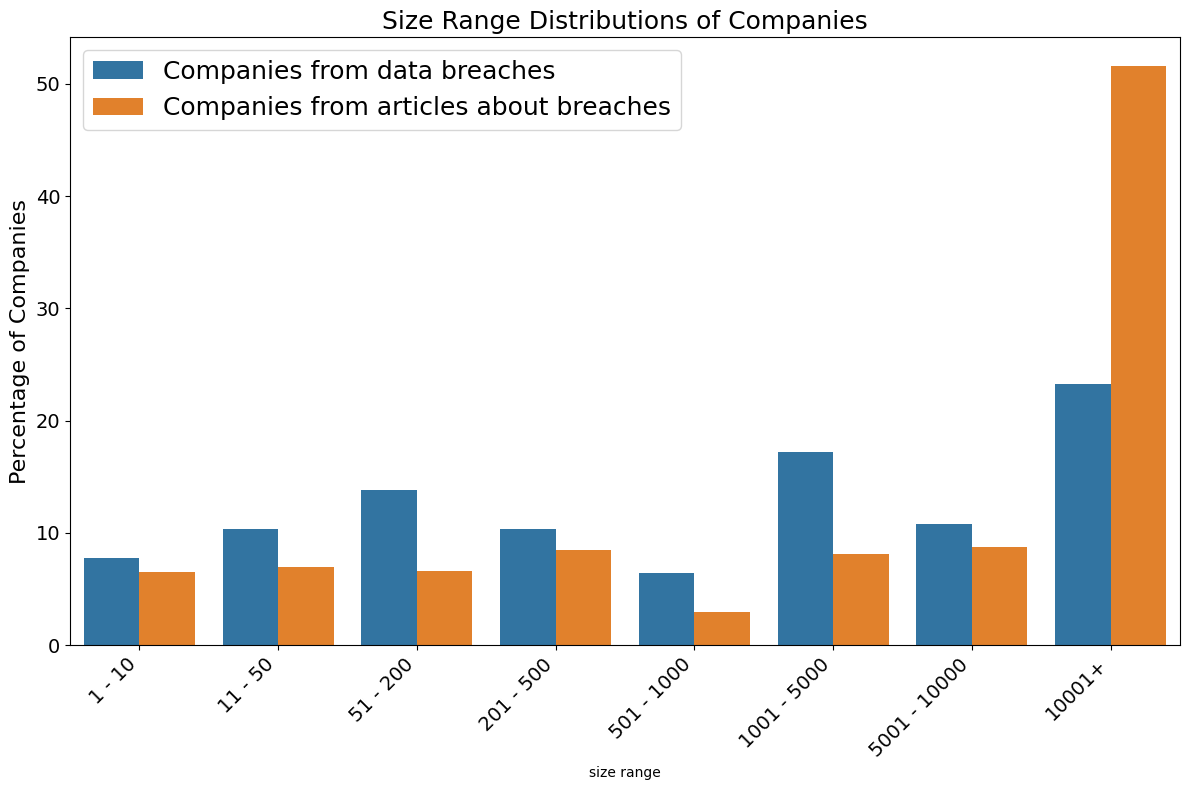

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
all_articles_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

all_articles = all_articles.dropna(subset=['size range'])

print(all_articles['size range'].unique())

# Define the bin order (adjust as per your actual bin range or desired order)
size_range_order = [
    "1 - 10", "11 - 50", "51 - 200", "201 - 500", "501 - 1000", "1001 - 5000",  # Example, modify this based on your data
    "5001 - 10000", "10001+"
]

# Convert 'size range' to a categorical type with the specified order
all_articles['size range'] = pd.Categorical(all_articles['size range'], categories=size_range_order, ordered=True)
breach_articles['size range'] = pd.Categorical(breach_articles['size range'], categories=size_range_order, ordered=True)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("size range").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["Companies from data breaches"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
breach_articles_counts = breach_articles.groupby("size range").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = breach_articles_counts["count_breach_articles"].sum()
breach_articles_counts["Companies from articles about breaches"] = (
    breach_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="size range",
    how="outer"
)

# Fill missing values with 0
# sector_percentages.fillna(0, inplace=True)

# Sort by the specified size range order
top_15_sectors = sector_percentages.sort_values(by="count_all_articles", ascending=False).head(15)

# Save the resulting table to a CSV file
output_file_path = "./output/size_breach_companies_percentages.csv"
top_15_sectors.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    top_15_sectors,
    id_vars="size range",
    value_vars=["Companies from data breaches", "Companies from articles about breaches"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="size range",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

# Customize plot labels and title
plt.title("Size Range Distributions of Companies", fontsize=18)
plt.ylabel("Percentage of Companies", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()


                                industry  count_all_articles  \
24                  consumer electronics                 3.0   
52                hospital & health care                15.0   
22                     computer software                17.0   
121                   telecommunications                12.0   
77             marketing and advertising                 5.0   
51                      higher education                 8.0   
6                             automotive                 2.0   
63                              internet                52.0   
19                        computer games                 7.0   
7                   aviation & aerospace                 0.0   
59   information technology and services                12.0   
96                       pharmaceuticals                 0.0   
90                          oil & energy                 2.0   
40                    financial services                15.0   
1                      airlines/aviation

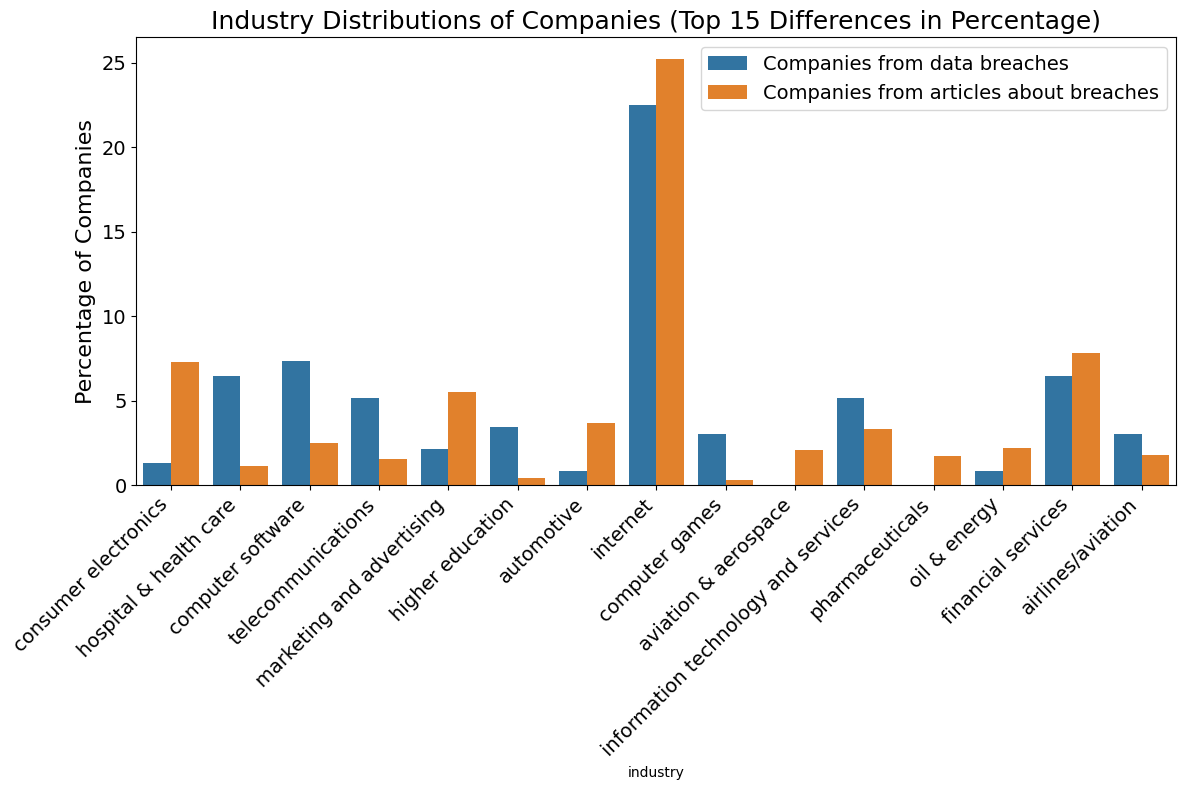

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to your CSV files
all_articles_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
companies_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

# Read the data
all_articles = pd.read_csv(all_articles_path)
companies_articles = pd.read_csv(companies_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["Companies from data breaches"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
companies_articles_counts = companies_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = companies_articles_counts["count_breach_articles"].sum()
companies_articles_counts["Companies from articles about breaches"] = (
    companies_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    companies_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

# Create a new column to calculate the absolute difference between the two percentages
sector_percentages["percentage_difference"] = abs(
    sector_percentages["Companies from data breaches"] - sector_percentages["Companies from articles about breaches"]
)

# Sort the dataframe by the absolute difference in percentages
sector_percentages = sector_percentages.sort_values(by="percentage_difference", ascending=False).head(15)

# Save the resulting table to a CSV file
output_file_path = "./output/sector_breach_companies_percentages.csv"
sector_percentages.to_csv(output_file_path, index=False)

# Print the resulting table to verify
print(sector_percentages)

# Plot the data
melted = pd.melt(
    sector_percentages,
    id_vars="industry",
    value_vars=["Companies from data breaches", "Companies from articles about breaches"],
    var_name="Article Type",
    value_name="Percentage"
)


plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="industry",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

plt.title("Industry Distributions of Companies (Top 15 Differences in Percentage)", fontsize=18)
plt.ylabel("Percentage of Companies", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


                      industry  count_all_articles  \
24        consumer electronics                 3.0   
77   marketing and advertising                 5.0   
6                   automotive                 2.0   
63                    internet                52.0   
7         aviation & aerospace                 0.0   
96             pharmaceuticals                 0.0   
90                oil & energy                 2.0   
40          financial services                15.0   
34               entertainment                 6.0   
113                restaurants                 1.0   
67             law enforcement                 1.0   
118                     sports                 0.0   
101                   printing                 0.0   
9                biotechnology                 0.0   
25              consumer goods                 0.0   

     Companies from data breaches  count_breach_articles  \
24                       1.298701                    926   
77             

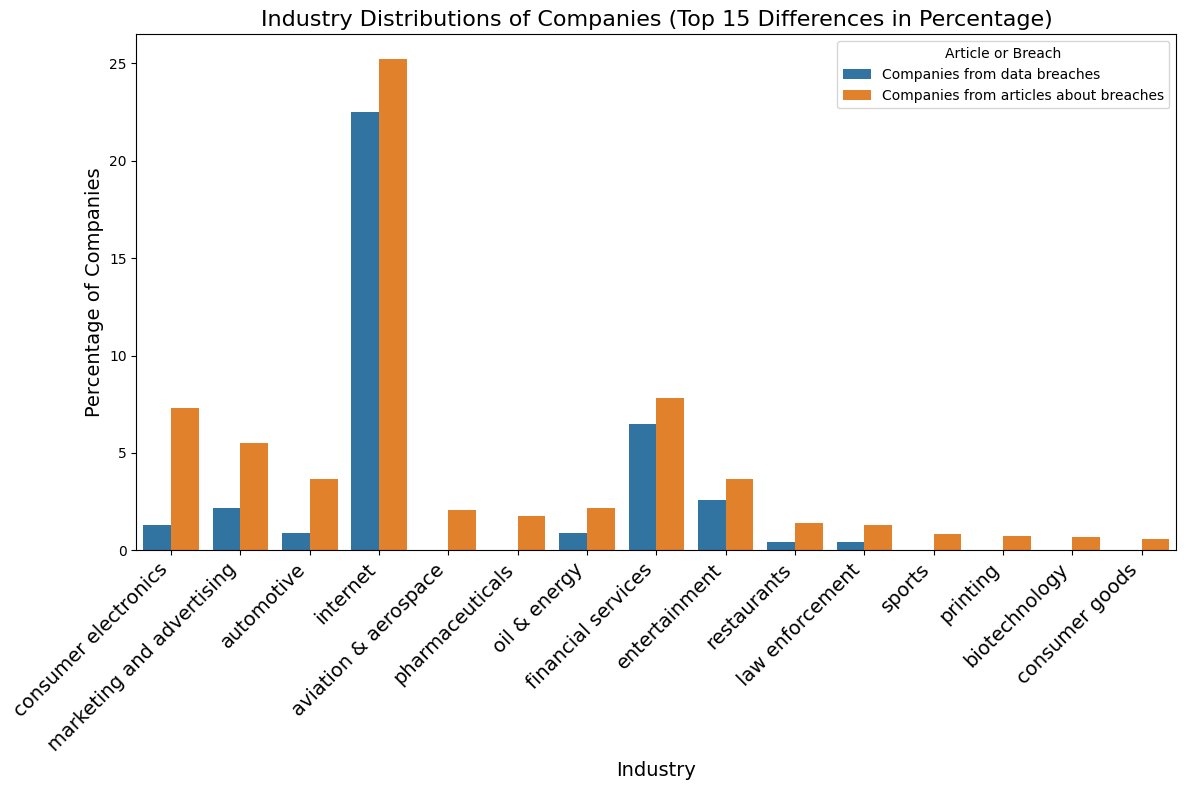

In [146]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to your CSV files
all_articles_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
companies_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

# Read the data
all_articles = pd.read_csv(all_articles_path)
companies_articles = pd.read_csv(companies_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["Companies from data breaches"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
companies_articles_counts = companies_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = companies_articles_counts["count_breach_articles"].sum()
companies_articles_counts["Companies from articles about breaches"] = (
    companies_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    companies_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

# Create a new column to calculate the absolute difference between the two percentages
sector_percentages["percentage_difference"] = (
    sector_percentages["Companies from articles about breaches"] - sector_percentages["Companies from data breaches"]
)

# Sort the dataframe by the absolute difference in percentages
sector_percentages = sector_percentages.sort_values(by="percentage_difference", ascending=False).head(15)

# Save the resulting table to a CSV file
output_file_path = "./output/sector_breach_companies_percentages.csv"
sector_percentages.to_csv(output_file_path, index=False)

# Print the resulting table to verify
print(sector_percentages)

# Plot the data
melted = pd.melt(
    sector_percentages,
    id_vars="industry",
    value_vars=["Companies from data breaches", "Companies from articles about breaches"],
    var_name="Article Type",
    value_name="Percentage"
)


plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="industry",
    y="Percentage",
    hue="Article Type",
    palette="tab10"
)

plt.title("Industry Distributions of Companies (Top 15 Differences in Percentage)", fontsize=16)
plt.xlabel("Industry", fontsize=14)
plt.ylabel("Percentage of Companies", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.legend(title="Article or Breach")

plt.tight_layout()
plt.show()


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Paths to your CSV files
all_articles_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
companies_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

# Read the data
all_articles = pd.read_csv(all_articles_path)
companies_articles = pd.read_csv(companies_articles_path)

# Group and count articles by industry for all articles
all_articles_counts = all_articles.groupby("industry").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["Companies from data breaches"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by industry for breach articles
companies_articles_counts = companies_articles.groupby("industry").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = companies_articles_counts["count_breach_articles"].sum()
companies_articles_counts["Companies from articles about breaches"] = (
    companies_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on industry
sector_percentages = pd.merge(
    all_articles_counts,
    companies_articles_counts,
    on="industry",
    how="outer"
)

# Fill missing values with 0
sector_percentages.fillna(0, inplace=True)

# Create a new column to calculate the absolute difference between the two percentages
sector_percentages["percentage_difference"] = (
    sector_percentages["Companies from articles about breaches"] - sector_percentages["Companies from data breaches"]
)

# Sort the dataframe by the absolute difference in percentages
sector_percentages = sector_percentages.sort_values(by="percentage_difference", ascending=False).head(15)

# Save the resulting table to a CSV file
output_file_path = "./output/sector_breach_companies_percentages.csv"
sector_percentages.to_csv(output_file_path, index=False)

# Print the resulting table to verify
print(sector_percentages)

# Melt the data for plotting
melted = pd.melt(
    sector_percentages,
    id_vars="industry",
    value_vars=["Companies from data breaches", "Companies from articles about breaches"],
    var_name="Article Type",
    value_name="Percentage"
)

# Compute the confidence intervals manually
z_score = 1.96  # For 95% confidence interval

# Define a function to compute the CI for each industry
def compute_ci(p, n):
    # Convert percentage to proportion
    p = p / 100
    # Calculate the margin of error
    margin_of_error = z_score * np.sqrt(p * (1 - p) / n)
    return margin_of_error * 100  # Convert back to percentage

# Sample size per industry: use the count of articles per industry for both "All Articles" and "Breach Articles"
sample_sizes = sector_percentages[["industry", "count_all_articles", "count_breach_articles"]]

# Apply CI calculation to each row for both article types
melted["ci"] = melted.apply(
    lambda row: compute_ci(
        row["Percentage"],
        sample_sizes[sample_sizes["industry"] == row["industry"]][f"count_{row['Article Type'].lower().replace(' ', '_')}"].values[0]
    ),
    axis=1
)

# Plot the data with manually calculated confidence intervals
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="industry",
    y="Percentage",
    hue="Article Type",
    palette="tab10",
    ci=None  # Disable Seaborn's automatic CI calculation
)

# Add error bars (confidence intervals)
for i, row in melted.iterrows():
    industry_index = melted[melted["industry"] == row["industry"]].index[0]
    plt.errorbar(
        x=industry_index,  # Use the correct x position
        y=row["Percentage"],  # The y position of the bar
        yerr=row["ci"],  # The CI error bar length
        fmt="none",  # No marker
        color="black",  # Error bar color
        capsize=5,  # Cap size for the error bars
    )

# Customize plot labels and title
plt.title("Industry Distributions of Companies (Top 15 Differences in Percentage)", fontsize=16)
plt.xlabel("Industry", fontsize=14)
plt.ylabel("Percentage of Companies", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.legend(title="Article or Breach")

# Show the plot
plt.tight_layout()
plt.show()


                      industry  count_all_articles  \
24        consumer electronics                 3.0   
77   marketing and advertising                 5.0   
6                   automotive                 2.0   
63                    internet                52.0   
7         aviation & aerospace                 0.0   
96             pharmaceuticals                 0.0   
90                oil & energy                 2.0   
40          financial services                15.0   
34               entertainment                 6.0   
113                restaurants                 1.0   
67             law enforcement                 1.0   
118                     sports                 0.0   
101                   printing                 0.0   
9                biotechnology                 0.0   
25              consumer goods                 0.0   

     Companies from data breaches  count_breach_articles  \
24                       1.298701                    926   
77             

KeyError: 'count_companies_from_data_breaches'

C:\Users\12537\AppData\Local\Temp\ipykernel_24056\910033103.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_articles_counts = all_articles.groupby("year_bin").size().reset_index(name="count_all_articles")
C:\Users\12537\AppData\Local\Temp\ipykernel_24056\910033103.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  breach_articles_counts = breach_articles.groupby("year_bin").size().reset_index(name="count_breach_articles")
C:\Users\12537\AppData\Local\Temp\ipykernel_24056\910033103.py:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot

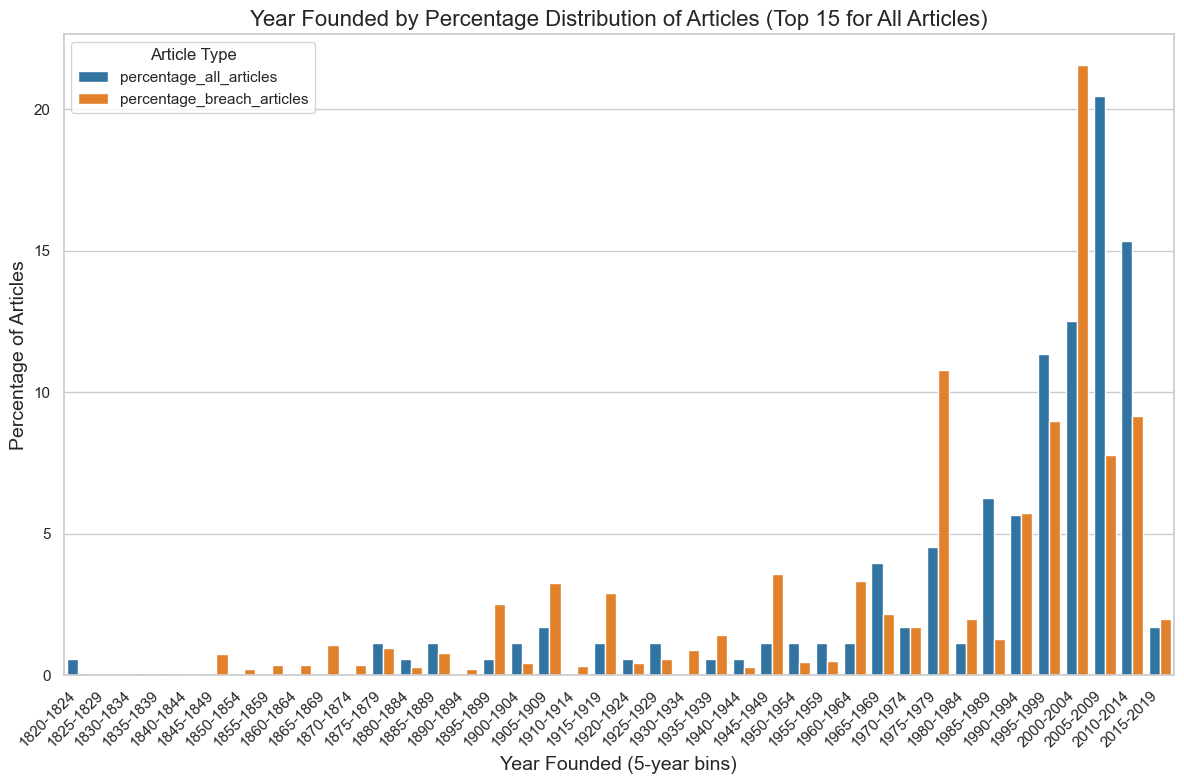

In [41]:


# Read the data
all_articles_path = "../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv"
breach_articles_path = "../../data/article_data/joined_articles_companies_no_duplicates.csv"

all_articles = pd.read_csv(all_articles_path)
breach_articles = pd.read_csv(breach_articles_path)

all_articles = all_articles.dropna(subset=['year founded'])
breach_articles = breach_articles.dropna(subset=['year founded'])


all_articles['year founded'] = all_articles['year founded'].astype(int)
breach_articles['year founded'] = breach_articles['year founded'].astype(int)

# Bin "year founded" into 5-year intervals
bins = range(all_articles["year founded"].min(), all_articles["year founded"].max() + 5, 5)
labels = [f"{i}-{i + 4}" for i in bins[:-1]]
all_articles["year_bin"] = pd.cut(all_articles["year founded"], bins=bins, labels=labels, right=False)
breach_articles["year_bin"] = pd.cut(breach_articles["year founded"], bins=bins, labels=labels, right=False)

# Group and count articles by year_bin for all articles
all_articles_counts = all_articles.groupby("year_bin").size().reset_index(name="count_all_articles")

# Calculate total articles to compute percentages
total_all_articles = all_articles_counts["count_all_articles"].sum()
all_articles_counts["percentage_all_articles"] = (
    all_articles_counts["count_all_articles"] / total_all_articles * 100
)

# Group and count articles by year_bin for breach articles
breach_articles_counts = breach_articles.groupby("year_bin").size().reset_index(name="count_breach_articles")

# Calculate total breach articles to compute percentages
total_breach_articles = breach_articles_counts["count_breach_articles"].sum()
breach_articles_counts["percentage_breach_articles"] = (
    breach_articles_counts["count_breach_articles"] / total_breach_articles * 100
)

# Merge the dataframes on year_bin
year_percentages = pd.merge(
    all_articles_counts,
    breach_articles_counts,
    on="year_bin",
    how="outer"
)

# Fill missing values with 0
#year_percentages.fillna(0, inplace=True)

# Sort by count_all_articles and select the top bins (optional)
top_15_years = year_percentages.sort_values(by="count_all_articles", ascending=False)

# Save the resulting table to a CSV file
output_file_path = "./output/year_founded_breach_companies_percentages.csv"
top_15_years.to_csv(output_file_path, index=False)

# Melt the data for plotting
melted = pd.melt(
    top_15_years,
    id_vars="year_bin",
    value_vars=["percentage_all_articles", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="year_bin",
    y="Percentage",
    hue="Article Type",
    palette="tab10",
    ci=95
)

# Customize plot labels and title
plt.title("Year Founded by Percentage Distribution of Articles (Top 15 for All Articles)", fontsize=16)
plt.xlabel("Year Founded (5-year bins)", fontsize=14)
plt.ylabel("Percentage of Articles", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()


## all data breaches vs data breaches with articles written about them


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to your CSV files
three_joined_path = "../../data/article_company_breach/correct_article_count_per_breach.csv"

# Read the data
df = pd.read_csv(three_joined_path)

# Define bin edges and labels for ranges
bin_edges = [0, 1000, 10000, 100000, 1000000, 2500000, 5000000, 10000000, 25000000, 50000000, 100000000, float('inf')]  # Adjust as needed
bin_labels = ["0-1K", "1K-10K", "10K-100K", "100K-1M", "1M-2.5M", "2.5M-5M", "5M-10M", "10M-25M", "25M-50M", "50M-100M", "100M+"]

# Ensure 'records lost' is numeric (convert or handle non-numeric values)
df['records lost'] = pd.to_numeric(df['records lost'], errors='coerce')

# Add a new column for the ranges
df['records_lost_range'] = pd.cut(df['records lost'], bins=bin_edges, labels=bin_labels, right=False)

# Save or inspect the results
output_path = "./output/records_lost_with_ranges.csv"
df.to_csv(output_path, index=False)

print("Updated dataset with 'records_lost_range' saved to:", output_path)


Updated dataset with 'records_lost_range' saved to: ./output/records_lost_with_ranges.csv


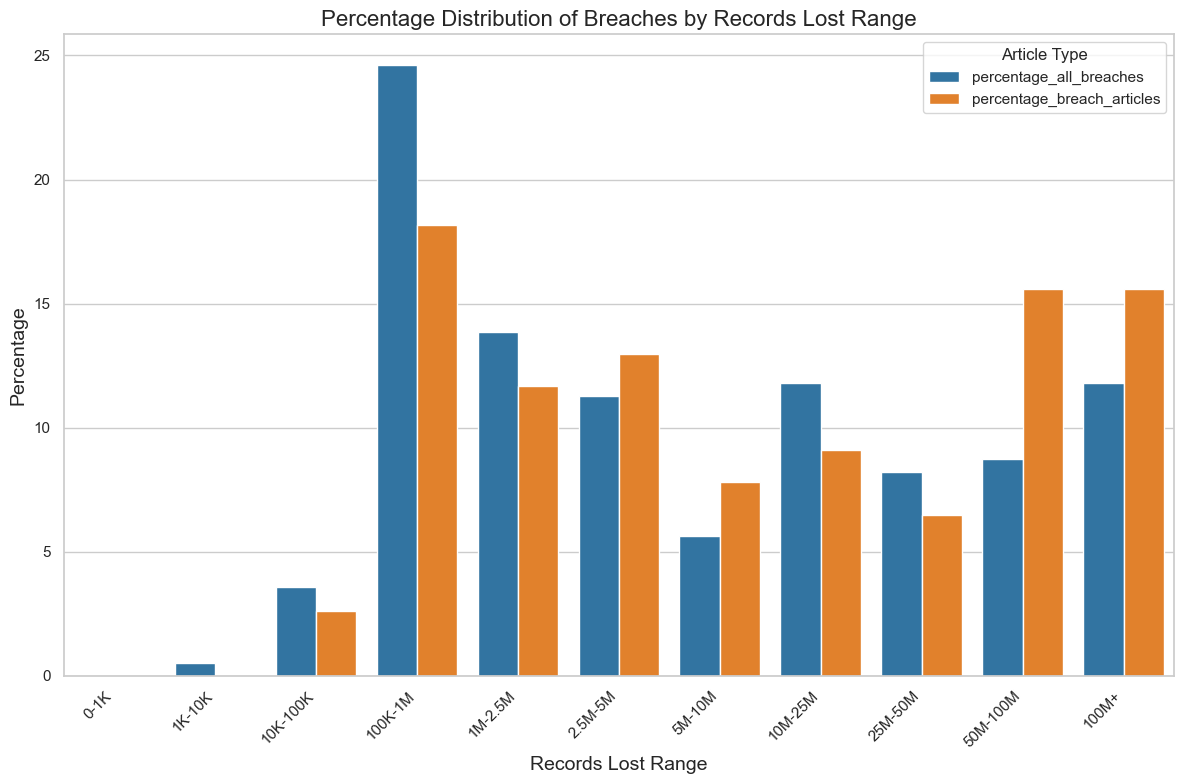

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "./output/records_lost_with_ranges.csv"
df = pd.read_csv(file_path)

# Determine if a breach has articles
df['HasArticle'] = df['number of articles'] > 0

# Total breaches per records_lost_range
all_breaches = df.groupby('records_lost_range').size().reset_index(name='count_all_breaches')

# Breaches with articles per records_lost_range
breach_articles = df[df['HasArticle']].groupby('records_lost_range').size().reset_index(name='count_breach_articles')

# Merge the counts
merged_counts = pd.merge(all_breaches, breach_articles, on='records_lost_range', how='outer').fillna(0)

# Calculate percentages
total_breaches = merged_counts['count_all_breaches'].sum()
total_breach_articles = merged_counts['count_breach_articles'].sum()

merged_counts['percentage_all_breaches'] = (merged_counts['count_all_breaches'] / total_breaches) * 100
merged_counts['percentage_breach_articles'] = (merged_counts['count_breach_articles'] / total_breach_articles) * 100

# Save the resulting table to a CSV file (optional)
output_file_path = "./output/records_lost_breach_percentages.csv"
merged_counts.to_csv(output_file_path, index=False)

# Define the order of bins for sorting
bin_order = ["0-1K", "1K-10K", "10K-100K", "100K-1M", "1M-2.5M", "2.5M-5M", "5M-10M", "10M-25M", "25M-50M", "50M-100M", "100M+"]

# Convert records_lost_range to a categorical type with the specified order
merged_counts['records_lost_range'] = pd.Categorical(
    merged_counts['records_lost_range'],
    categories=bin_order,
    ordered=True
)

# Sort the data by the categorical order
merged_counts = merged_counts.sort_values('records_lost_range')

# Melt the data for plotting
melted = pd.melt(
    merged_counts,
    id_vars="records_lost_range",
    value_vars=["percentage_all_breaches", "percentage_breach_articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="records_lost_range",
    y="Percentage",
    hue="Article Type",
    palette="tab10",
)

# Customize plot labels and title
plt.title("Percentage Distribution of Breaches by Records Lost Range", fontsize=16)
plt.xlabel("Records Lost Range", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Article Type")

# Show the plot
plt.tight_layout()
plt.show()



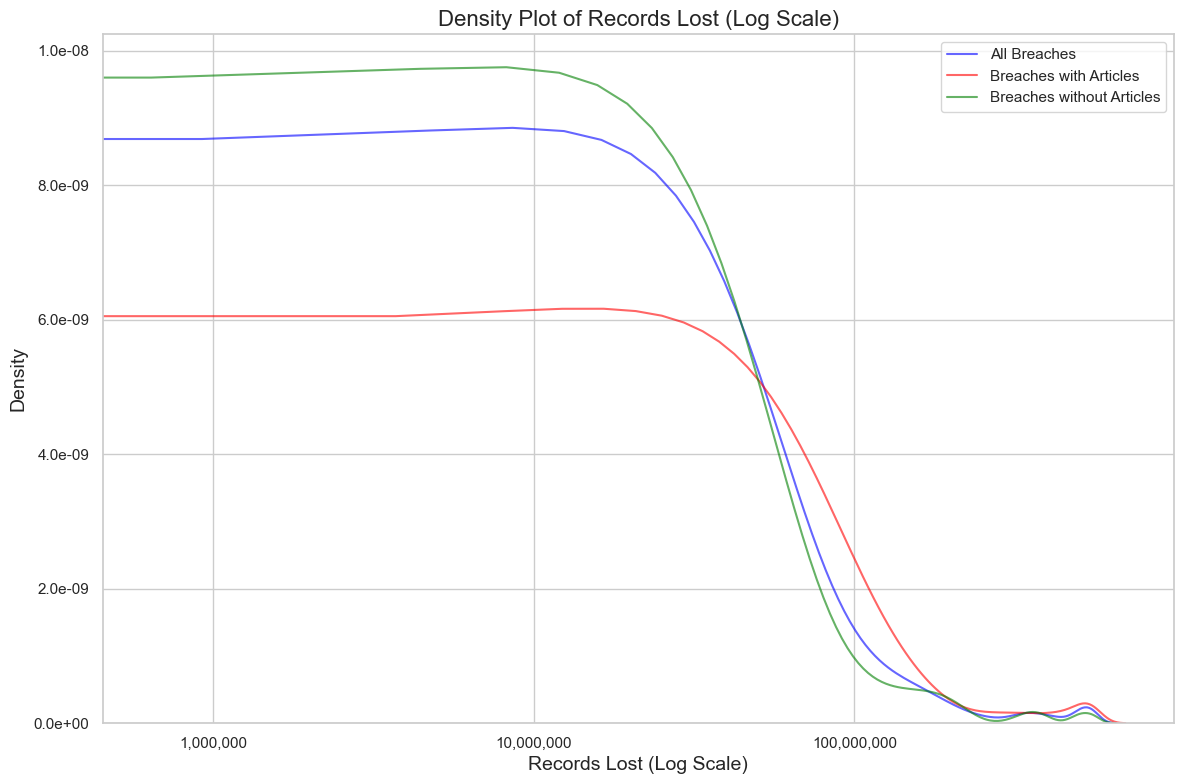

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the dataset
file_path = "./output/records_lost_with_ranges.csv"
df = pd.read_csv(file_path)

# Determine if a breach has articles
df['HasArticle'] = df['number of articles'] > 0

# Filter breaches with articles
df_with_articles = df[df['HasArticle']]

# Filter breaches without articles
df_without_articles = df[~df['HasArticle']]

# Create the KDE plot for all records
plt.figure(figsize=(12, 8))

# KDE for all breaches (with and without articles)
sns.kdeplot(
    data=df,
    x="records lost",
    fill=False,  # Fill under the curve
    color="blue",
    alpha=0.6,  # Transparency
    common_norm=True,  # Ensure the area under the curve sums to 1
    label="All Breaches"  # Label for the legend
)

# KDE for breaches with articles
sns.kdeplot(
    data=df_with_articles,
    x="records lost",
    fill=False,  # Fill under the curve
    color="red",
    alpha=0.6,  # Transparency
    common_norm=True,  # Ensure the area under the curve sums to 1
    label="Breaches with Articles"  # Label for the legend
)

# KDE for breaches without articles
sns.kdeplot(
    data=df_without_articles,
    x="records lost",
    fill=False,  # Fill under the curve
    color="green",
    alpha=0.6,  # Transparency
    common_norm=True,  # Ensure the area under the curve sums to 1
    label="Breaches without Articles"  # Label for the legend
)

# Set log scale for x-axis
plt.xscale('log')  # Apply log scale to the x-axis

# Customize the plot title and labels
plt.title("Density Plot of Records Lost (Log Scale)", fontsize=16)
plt.xlabel("Records Lost (Log Scale)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Improve x-axis label formatting for log scale
def format_xaxis(x, pos):
    return f'{int(x):,}'  # Adds commas for thousands

# Improve y-axis label formatting (show 3 decimal places or scientific notation if very small)
def format_yaxis(y, pos):
    if y < 0.0001:
        return f'{y:.1e}'  # Scientific notation for very small values
    return f'{y:.3f}'  # 3 decimal places

# Apply custom formatters
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xaxis))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Add legend
plt.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


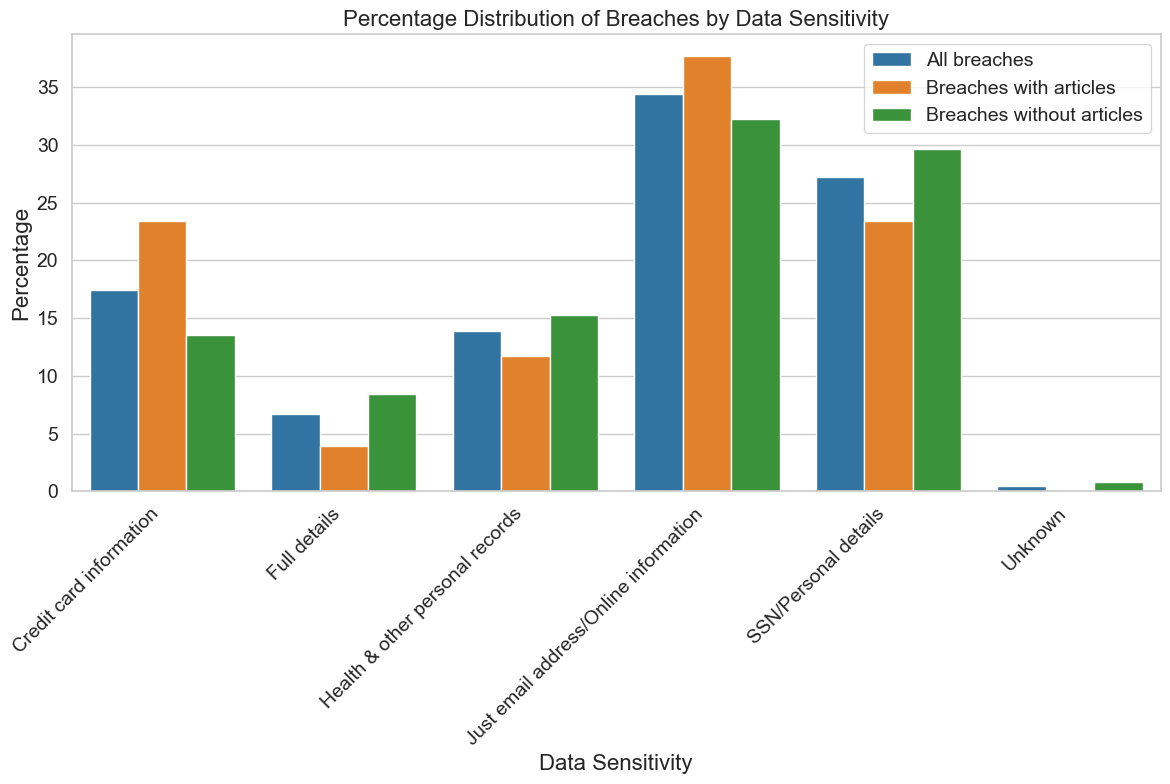

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "../../data/article_company_breach/correct_article_count_per_breach.csv"
df = pd.read_csv(file_path)

# Mapping for data sensitivity
mapping = {
    0.0: "Unknown",
    1.0: "Just email address/Online information",
    2.0: "SSN/Personal details",
    3.0: "Credit card information",
    4.0: "Health & other personal records",
    5.0: "Full details"
}

# Apply the mapping to the column
df['data sensitivity'] = df['data sensitivity'].map(mapping)

# Determine if a breach has articles
df['HasArticle'] = df['number of articles'] > 0

# Total breaches per data sensitivity
all_breaches = df.groupby('data sensitivity').size().reset_index(name='count_all_breaches')

# Breaches with articles per data sensitivity
breach_articles = df[df['HasArticle']].groupby('data sensitivity').size().reset_index(name='count_breach_articles')

# Breaches without articles per data sensitivity
breach_no_articles = df[~df['HasArticle']].groupby('data sensitivity').size().reset_index(name='count_breach_no_articles')

# Merge the counts
merged_counts = pd.merge(all_breaches, breach_articles, on='data sensitivity', how='outer').fillna(0)
merged_counts = pd.merge(merged_counts, breach_no_articles, on='data sensitivity', how='outer').fillna(0)

# Calculate percentages
total_breaches = merged_counts['count_all_breaches'].sum()
total_breach_articles = merged_counts['count_breach_articles'].sum()
total_breach_no_articles = merged_counts['count_breach_no_articles'].sum()

merged_counts['percentage_all_breaches'] = (merged_counts['count_all_breaches'] / total_breaches) * 100
merged_counts['percentage_breach_articles'] = (merged_counts['count_breach_articles'] / total_breach_articles) * 100
merged_counts['percentage_breach_no_articles'] = (merged_counts['count_breach_no_articles'] / total_breach_no_articles) * 100

# Sort the data
merged_counts = merged_counts.sort_values('data sensitivity')

merged_counts["All breaches"] = merged_counts["percentage_all_breaches"]
merged_counts["Breaches with articles"] = merged_counts["percentage_breach_articles"]
merged_counts["Breaches without articles"] = merged_counts["percentage_breach_no_articles"]

# Melt the data for plotting
melted = pd.melt(
    merged_counts,
    id_vars="data sensitivity",
    value_vars=["All breaches", "Breaches with articles", "Breaches without articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="data sensitivity",
    y="Percentage",
    hue="Article Type",
    palette="tab10",
)

# Customize plot labels and title
plt.title("Percentage Distribution of Breaches by Data Sensitivity", fontsize=16)
plt.xlabel("Data Sensitivity", fontsize=16)
plt.ylabel("Percentage", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.legend( fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


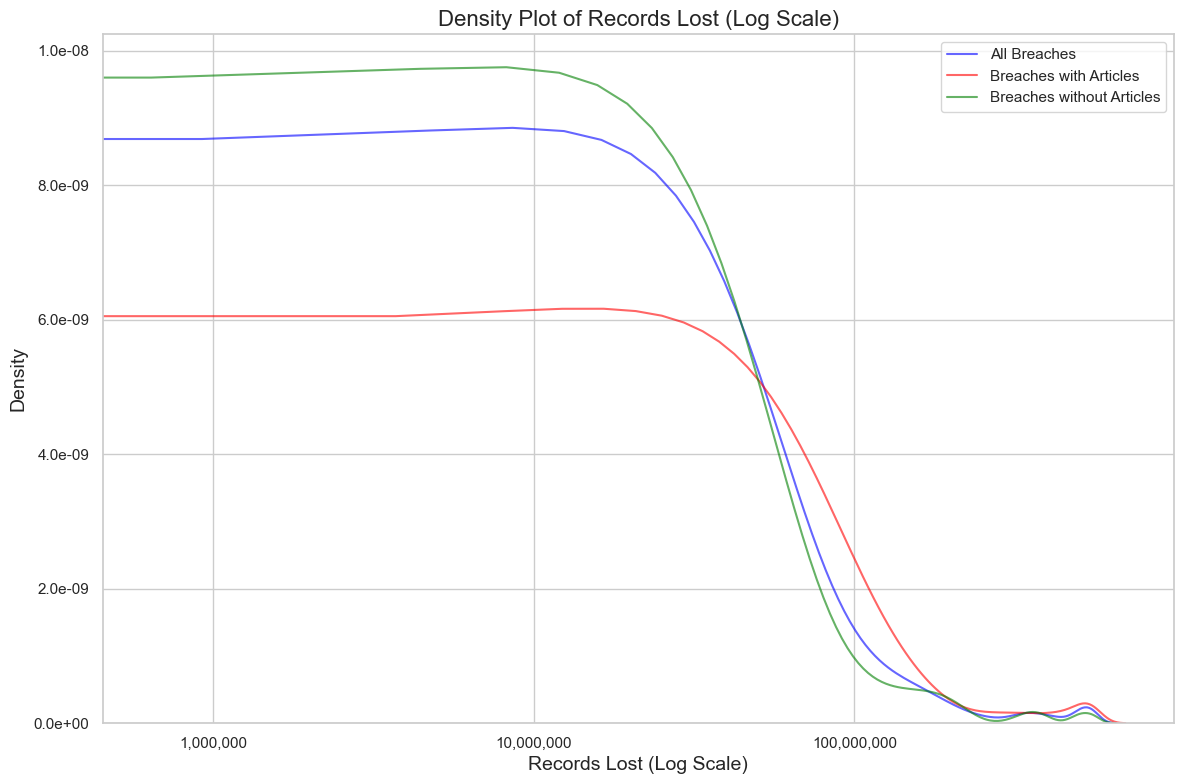

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the dataset
file_path = "./output/records_lost_with_ranges.csv"
df = pd.read_csv(file_path)

# Determine if a breach has articles
df['HasArticle'] = df['number of articles'] > 0

# Filter breaches with articles
df_with_articles = df[df['HasArticle']]

# Filter breaches without articles
df_without_articles = df[~df['HasArticle']]

# Create the KDE plot for all records
plt.figure(figsize=(12, 8))

# KDE for all breaches (with and without articles)
sns.kdeplot(
    data=df,
    x="records lost",
    fill=False,  # Fill under the curve
    color="blue",
    alpha=0.6,  # Transparency
    common_norm=True,  # Ensure the area under the curve sums to 1
    label="All Breaches"  # Label for the legend
)

# KDE for breaches with articles
sns.kdeplot(
    data=df_with_articles,
    x="records lost",
    fill=False,  # Fill under the curve
    color="red",
    alpha=0.6,  # Transparency
    common_norm=True,  # Ensure the area under the curve sums to 1
    label="Breaches with Articles"  # Label for the legend
)

# KDE for breaches without articles
sns.kdeplot(
    data=df_without_articles,
    x="records lost",
    fill=False,  # Fill under the curve
    color="green",
    alpha=0.6,  # Transparency
    common_norm=True,  # Ensure the area under the curve sums to 1
    label="Breaches without Articles"  # Label for the legend
)

# Set log scale for x-axis
plt.xscale('log')  # Apply log scale to the x-axis

# Customize the plot title and labels
plt.title("Density Plot of Records Lost (Log Scale)", fontsize=16)
plt.xlabel("Records Lost (Log Scale)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Improve x-axis label formatting for log scale
def format_xaxis(x, pos):
    return f'{int(x):,}'  # Adds commas for thousands

# Improve y-axis label formatting (show 3 decimal places or scientific notation if very small)
def format_yaxis(y, pos):
    if y < 0.0001:
        return f'{y:.1e}'  # Scientific notation for very small values
    return f'{y:.3f}'  # 3 decimal places

# Apply custom formatters
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xaxis))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Add legend
plt.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


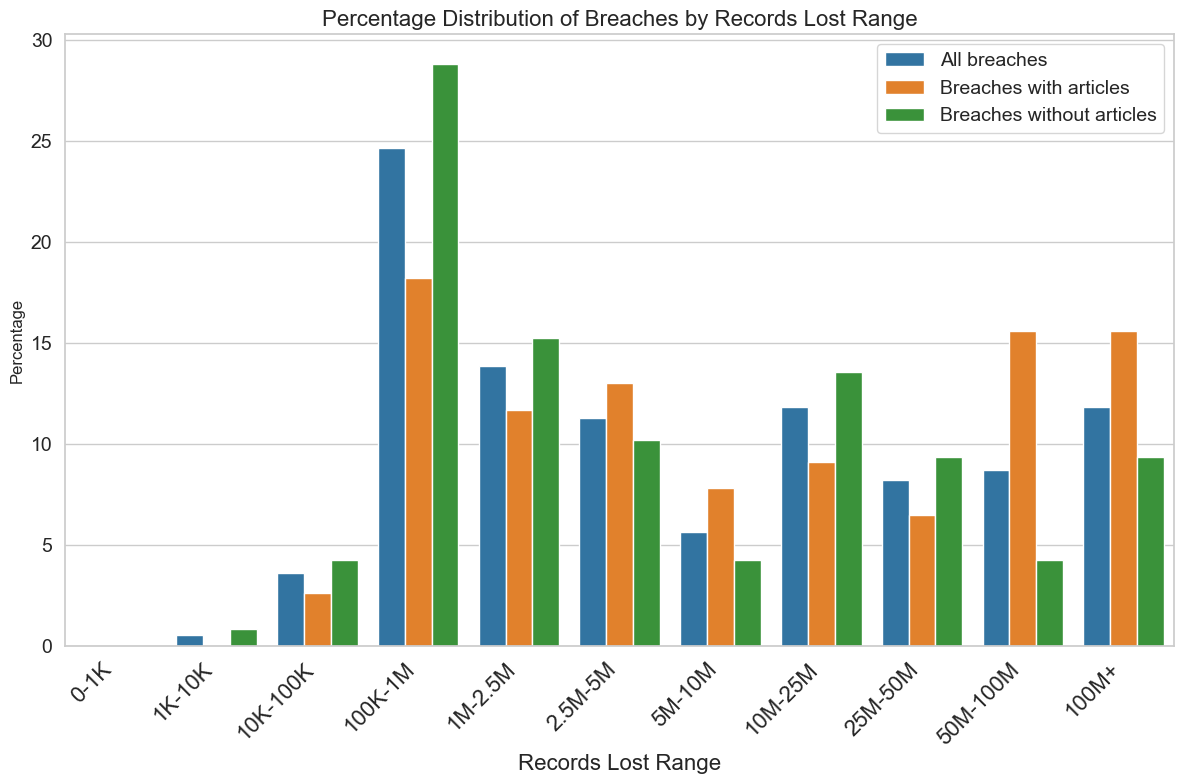

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "./output/records_lost_with_ranges.csv"
df = pd.read_csv(file_path)

# Determine if a breach has articles
df['HasArticle'] = df['number of articles'] > 0

# Total breaches per records_lost_range
all_breaches = df.groupby('records_lost_range').size().reset_index(name='count_all_breaches')

# Breaches with articles per records_lost_range
breach_articles = df[df['HasArticle']].groupby('records_lost_range').size().reset_index(name='count_breach_articles')

# Breaches without articles per records_lost_range
breach_no_articles = df[~df['HasArticle']].groupby('records_lost_range').size().reset_index(name='count_breach_no_articles')

# Merge the counts
merged_counts = pd.merge(all_breaches, breach_articles, on='records_lost_range', how='outer').fillna(0)
merged_counts = pd.merge(merged_counts, breach_no_articles, on='records_lost_range', how='outer').fillna(0)

# Calculate percentages
total_breaches = merged_counts['count_all_breaches'].sum()
total_breach_articles = merged_counts['count_breach_articles'].sum()
total_breach_no_articles = merged_counts['count_breach_no_articles'].sum()

merged_counts['percentage_all_breaches'] = (merged_counts['count_all_breaches'] / total_breaches) * 100
merged_counts['percentage_breach_articles'] = (merged_counts['count_breach_articles'] / total_breach_articles) * 100
merged_counts['percentage_breach_no_articles'] = (merged_counts['count_breach_no_articles'] / total_breach_no_articles) * 100

# Save the resulting table to a CSV file (optional)
output_file_path = "./output/records_lost_breach_percentages.csv"
merged_counts.to_csv(output_file_path, index=False)

# Define the order of bins for sorting
bin_order = ["0-1K", "1K-10K", "10K-100K", "100K-1M", "1M-2.5M", "2.5M-5M", "5M-10M", "10M-25M", "25M-50M", "50M-100M", "100M+"]

# Convert records_lost_range to a categorical type with the specified order
merged_counts['records_lost_range'] = pd.Categorical(
    merged_counts['records_lost_range'],
    categories=bin_order,
    ordered=True
)

# Sort the data by the categorical order
merged_counts = merged_counts.sort_values('records_lost_range')

merged_counts["All breaches"] = merged_counts["percentage_all_breaches"]
merged_counts["Breaches with articles"] = merged_counts["percentage_breach_articles"]
merged_counts["Breaches without articles"] = merged_counts["percentage_breach_no_articles"]

# Melt the data for plotting
melted = pd.melt(
    merged_counts,
    id_vars="records_lost_range",
    value_vars=["All breaches", "Breaches with articles", "Breaches without articles"],
    var_name="Article Type",
    value_name="Percentage"
)

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted,
    x="records_lost_range",
    y="Percentage",
    hue="Article Type",
    palette="tab10",
)

# Customize plot labels and title
plt.title("Percentage Distribution of Breaches by Records Lost Range", fontsize=16)
plt.xlabel("Records Lost Range", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)



# Show the plot
plt.tight_layout()
plt.show()
